# Classifiez automatiquement des biens de consommation

## Compréhension du problème

----------------------------------------------------------------------------------------------------------

###  Mission

----------------------------------------------------------------------------------------------------------
- Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.

- réaliser une première étude de faisabilité d'un moteur de classification, d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

- analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering, à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters.

- illustre que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

- démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des produits de même catégorie

----------------------------------------------------------------------------------------------------------

 ### Requirements : Bibliothèques utilisées dans ce notebook
 
 ----------------------------------------------------------------------------------------------------------
  ----------------------------------------------------------------------------------------------------------
 
 
 ## Partie 01: Classification Texte 
 
  ----------------------------------------------------------------------------------------------------------
 


**Import des bibliothèques**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List
import transformers
import gensim
import nltk
from nltk import PorterStemmer, WordNetLemmatizer, word_tokenize, FreqDist
from nltk.corpus import stopwords  
from nltk.tokenize import sent_tokenize, word_tokenize    
import string as st
from sklearn import cluster ,manifold, decomposition ,preprocessing ,metrics
from sklearn.cluster import  KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from yellowbrick.cluster import SilhouetteVisualizer
import time
import os
import transformers
import tensorflow_hub
import tensorflow as tf
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


**Configuration défauts d'affichage**

In [3]:

from sklearn import set_config

pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 100)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

set_config(display='diagram')


### Chargement des données

In [4]:
# Chargement du jeu de données
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [5]:
data.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                                                                           product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1           http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2  http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   
2                         Eurospa Cotton Terry Face Towel Set   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z       1899.00            899.00   
1  BTWEGFZHGBXPHZUH        600.00            449.00   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                                                                                product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value...  
1  {"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "val...  
2  {"product_specification"=>[{"key"=>"Material", "value"=>"Cotton Terry"}, {"key"=>"Design", "valu...

#### Connaissance du jeu de données et Nettoyage

In [6]:
#Création d'une fonction pour analyser la structure des dataframes

def data_structure(data):
    ''' Affiche la structure du dataframe'''
    
    # comptage des colonnes numériques et catégorielles
    numeric_columns = len(data.select_dtypes(include = ['int64','float64']).columns)
    categorical_columns= len(data.select_dtypes(include=['object','category']).columns)

    # création d'un dictionnaire avec les items de structure de nos données
    dict_structure = {'Nombre de lignes':data.shape[0], 'Nombre de colonnes':int(data.shape[1]), 
                      'Nombre de variables catégorielles':categorical_columns,
                      'Nombre de variables numériques ':numeric_columns,
                      'Pourcentage de données manquantes':int((data.isnull().sum()/len(data)*100).sum()),
                      'Nombre de doublons':int(len(data[data.duplicated()]))}

    # transformation des éléments du dictionnaire en dataframe
    dataframe =pd.DataFrame(list(dict_structure.items()),columns=['Caractéristiques','Valeurs'])
    return dataframe

In [7]:
data_structure(data)

Caractéristiques  Valeurs
0                   Nombre de lignes     1050
1                 Nombre de colonnes       15
2  Nombre de variables catégorielles       12
3    Nombre de variables numériques         2
4  Pourcentage de données manquantes       32
5                 Nombre de doublons        0

In [8]:
# Fonction pour afficher le pourcentage des valeurs nulls et les visualiser 

def valeur_null (df, pourcentage,heatmap):
   

    # 1. Nombre de valeurs manquantes totales
    nb_nan_tot = df.isna().sum().sum()
    nb_donnees_tot = np.product(df.shape)
    pourc_nan_tot = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    print(
        f'Valeurs manquantes :{nb_nan_tot} NaN pour {nb_donnees_tot} données ({pourc_nan_tot} %)')

    if pourcentage:
        print("-------------------------------------------------------------")
        print("Nombre et pourcentage de valeurs manquantes par variable\n")
        # 2. Visualisation du nombre et du pourcentage de valeurs manquantes
        # par variable
        values = df.isnull().sum()
        percentage = 100 * values / len(df)
        table = pd.concat([values, percentage.round(2)], axis=1)
        table.columns = [
            'Nombres de valeurs manquantes',
            '% de valeurs manquantes']
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending=False)
               )
    

    if heatmap:
        print("-------------------------------------------------------------")
        print("Heatmap de visualisation des valeurs manquantes")
        # 3. Heatmap de visualisation des valeurs manquantes
        plt.figure(figsize=(20, 10))
        sns.heatmap(df.isna(), cbar=False)
        plt.show()

Valeurs manquantes :341 NaN pour 15750 données (2.17 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  % de valeurs manquantes
brand                                             338                    32.19
retail_price                                        1                     0.10
discounted_price                                    1                     0.10
product_specifications                              1                     0.10

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


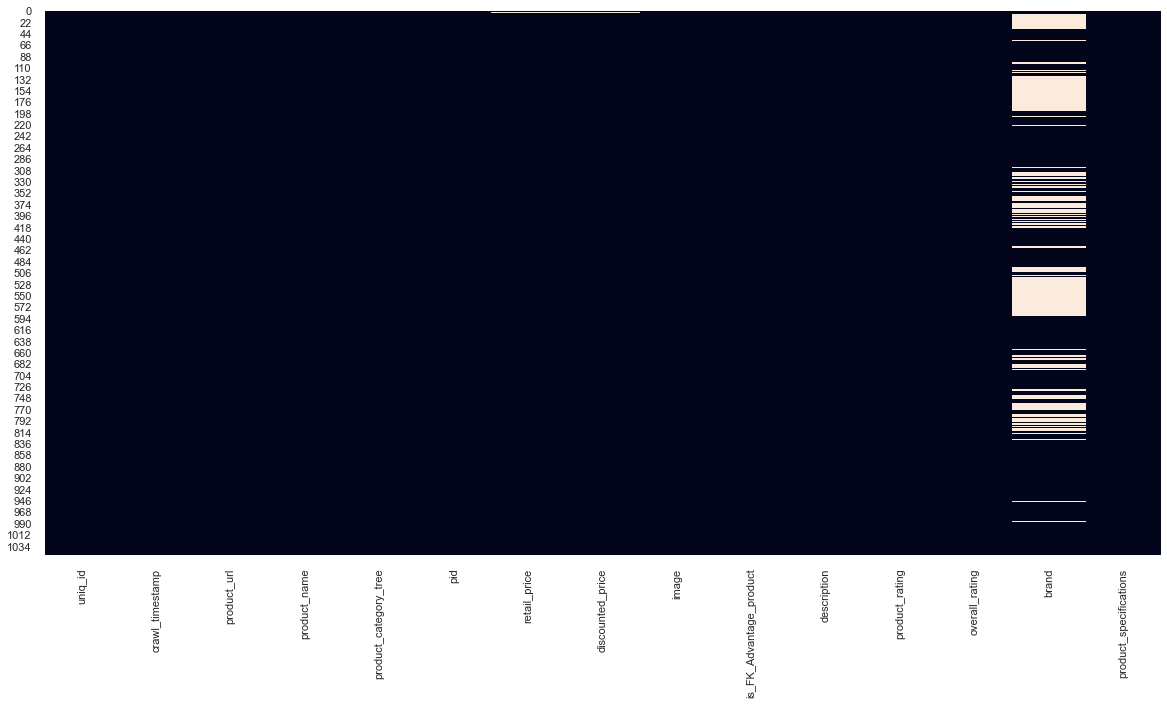

In [9]:
valeur_null (data, True ,True)

#### Remplissage de données manquantes


Il y a peu de données manquantes . 32% des données n'ont pas de brand

In [10]:

def fill_missing_values(df: pd.DataFrame):
    if 'brand' in df.columns:
        df = df.copy()
        df['brand'] = df['brand'].fillna('missing')
    return df


data = data.pipe(fill_missing_values)

#### crawl_timestamp - Horodatage

In [11]:
# Transforme de Object en Datetime
data['crawl_timestamp'] = pd.to_datetime(data['crawl_timestamp'])
# Période de notre sous-jeu de données
min = data['crawl_timestamp'].min().strftime('%d/%m/%Y')
max = data['crawl_timestamp'].max().strftime('%d/%m/%Y')
print(f'Période d\'ajout des produits : du {min} au {max}')

Période d'ajout des produits : du 01/12/2015 au 26/06/2016


### Les catégories produits

Chaque produit est catégorisée par un système d'arbres avec plusieurs niveaux. Le nom de la colonne renseignant les catégories est product_category_tree.

In [12]:
# Exemple de la catégorie d'un produit
print(data["product_category_tree"][0])

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


In [13]:
# On récupère la colomne "product_category_tree"
list_categories_0, list_categories_1 = [], []
for txt in data["product_category_tree"] :
    
    list_categories_0.append(txt.split(">>")[0].split("\"")[1].strip()) # split du nom par >> et on récupère la première partie
    list_categories_1.append(txt.split(">>")[1].strip()) # split du nom par >> et on récupère la première partie

# Création d'une nouvelle série catégorie    
data["category_0"] = pd.Series(list_categories_0)
data["category_1"] = pd.Series(list_categories_1)

print("Il y a {} catégories de niveau 0 et {} categories de niveau 1".format(data["category_0"].nunique(), data["category_1"].nunique()))


Il y a 7 catégories de niveau 0 et 63 categories de niveau 1


- **Affichage des catégories de niveau 0**

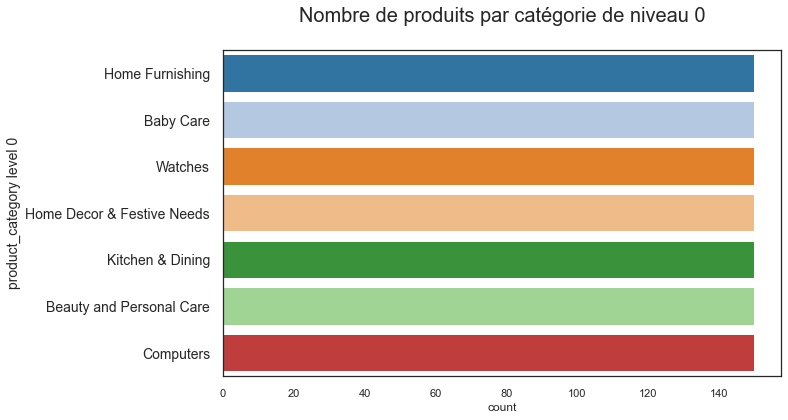

In [14]:
fig = plt.figure(figsize=(10, 6))
sns.countplot(data=data, y="category_0",
             order = data["category_0"].value_counts().index,)
plt.yticks(size=14)
plt.title(f"Nombre de produits par catégorie de niveau 0\n",
          fontsize=20)
plt.ylabel("product_category level 0", fontsize=14)
plt.show()

- **Affichage des catégories de niveau 1**

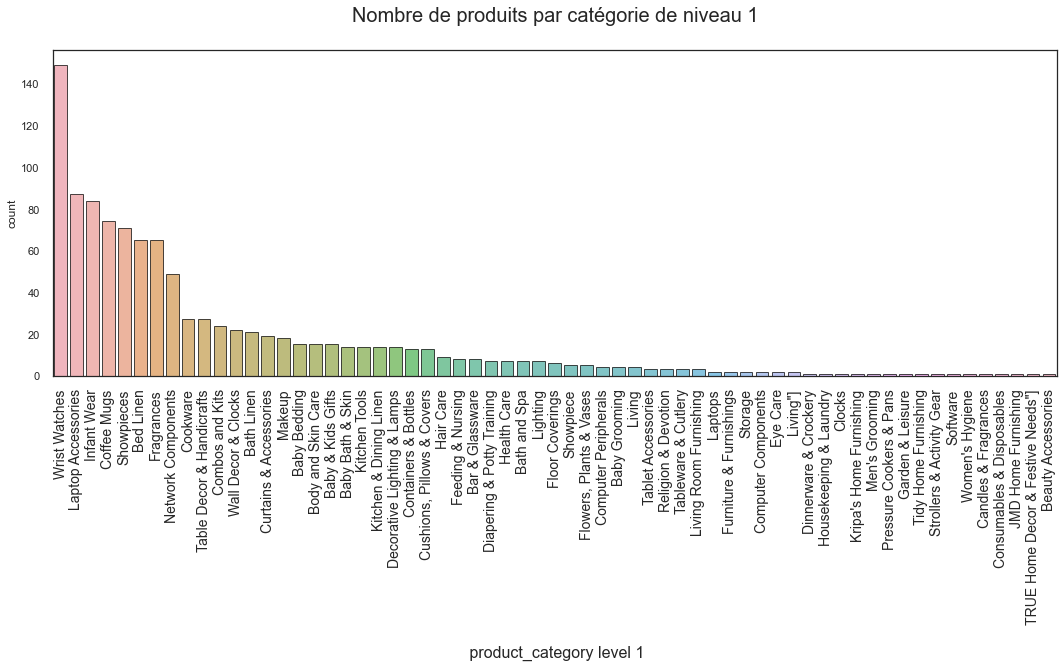

In [15]:

fig = plt.figure(figsize=(18, 6))
sns.countplot(data=data, x="category_1",
              edgecolor="black",
              order = data['category_1'].value_counts().index,
              alpha=0.7)
plt.xticks(rotation=90, size=14)
plt.title(f"Nombre de produits par catégorie de niveau 1\n",
          fontsize=20)
plt.xlabel('\n product_category level 1', fontsize=16)
plt.show()

In [16]:
data.category_0

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category_0, Length: 1050, dtype: object

In [17]:
# Chargement du jeu de données
data.to_csv('data_net.csv',index=False )

## Pré-traitement


Préparation des données, les rendant exploitables pour l'automatisation des catégorisation.



 ### Sélection des features à traiter
Seules 3 features nous interresse dans cette partie :

- **'product_name'** correspond au titre du produit
- **'description'** comme son nom l'indique, à sa description
- **'category_0'** renseigne sur la catégorie du produit de niveau 0 .



In [18]:
# Constitution du dataframe de travail
df_txt = data.copy()[['category_0','product_name','description']]
df_txt.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                           description  
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...  
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...

 - **Fusion des colonnes 'product_name' et 'description'**
 
 
 
Je fusionne le titre et la description du produit
pour ne garder qu'un unique champ contenant
l'ensemble des termes décrivant l'objet.


In [19]:
#Fusion des colonnes

df_txt['name_desc'] = df_txt['product_name']+' '+df_txt['description']
df_txt.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

                                                                                             name_desc  
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...  
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...

 ## Traitement des descriptions



 
- **Suppression des ponctuations**

 Supprimer tous les string.punctuation (! "# $% & '() * +, -. / :; <=>? @ [] ^ _` {|} ~).

In [20]:
def sup_punct(text):
    '''
   Suppression des ponctuations
    
    '''
    return ("".join([ch for ch in text if ch not in st.punctuation]))

In [21]:
df_txt['remove_punc'] = df_txt['name_desc'].apply(lambda x:sup_punct(x))
df_txt.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                           remove_punc  
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...  
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel 3 Bath Towel Red Yellow ...

In [22]:
#   1. Suppression des liens hypertexte
#   2. Suppression des Tags
#   3. Suppression des emoticones
#   4. Suppression des chiffres

import emoji

def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def pre_traite(com):
    com = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|''(?:%[0-9a-fA-F][0-9a-fA-F]))+',"", com)
    com = re.sub("(@[A-Za-z0-9_]+)","", com)
    com = re.sub("(#[A-Za-z0-9_]+)","", com)
    com = give_emoji_free_text(com)
    
    res = ''.join(i for i in com if not i.isdigit())   # sup les chiffres
    return(res)

In [23]:
df_txt['remove_emoj'] = df_txt['name_desc'].apply(lambda x:give_emoji_free_text(x))
df_txt.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel 3 Bath Towel Red Yellow ...   

                                                                                           remove_emoj  
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...  
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...

In [24]:
df_txt['remove_punc'] = df_txt['remove_emoj'].apply(lambda x:pre_traite(x))
df_txt.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel ( Bath Towel, Red, Yello...   

                                                                                           remove_emoj  
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...  
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...

 - **Tokenisation**
 
la tokenisation des textes qui consiste à identifier les unités de textes élémentaires (tokens) qui peuvent être des mots, mais aussi des lettres, des syllabes, des phrases, ou des séquences de ces éléments. C'est la Pemière phase de définition de l'objet de l'analyse 

- Si les mots sont des unités de sens évidentes, les paires, les triplets de mots le sont aussi (n-grammes).
- à partir de ces tokens, l'analyse de la fréquence des mots peut être effectuée pour construire un dictionnaire permettant de filtrer les tokens selon leurs fréquences.
les tokens les plus fréquents qui n'apportent donc aucune information sont supprimés.
les tokens très peu fréquents qui apportent une information singulière sont également supprimés.

In [25]:
def tokenize(text):
    '''
    Convert text to lower case tokens. Here, split() is applied on white-spaces. But,
    it could be applied on special characters, tabs or any other string based on which
    text is to be seperated into tokens.
    
    '''
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]


In [26]:
#tokenizer = nltk.RegexpTokenizer(r'\w+')

#def tokenize(text):
   # com = tokenizer.tokenize(text.lower())   # majuscule -> minuscule
    #com = tokenizer.tokenize(com)
    #return(text)

In [27]:
# tokonize

df_txt['tokens'] = df_txt['remove_punc'].apply(lambda x : word_tokenize(x))
df_txt.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel ( Bath Towel, Red, Yello...   

                                                                                           remove_emoj  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                                tokens  
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, of, Elegance, ...  
1  [Sathiyas, Cotton, Bath, Towel, Specifications, of, Sathiyas, Cotton, Bath, Towel, (, Bath, Towe...

- **Suppression les mots de taille < 2** 


In [28]:
def remove_small_words(text):
    '''
    Suppression les mots de taille <2 
    '''
    return [x for x in text if len(x) >2 ]


In [29]:
df_txt['tokens'] = df_txt['tokens'].apply(lambda x : remove_small_words(x))
df_txt.head(3)

category_0  \
0  Home Furnishing   
1        Baby Care   
2        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   
2                         Eurospa Cotton Terry Face Towel Set   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   
2  Eurospa Cotton Terry Face Towel Set Key Features of Eurospa Cotton Terry Face Towel Set Size: sm...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel ( Bath Towel, Red, Yello...   
2  Eurospa Cotton Terry Face Towel Set Key Features of Eurospa Cotton Terry Face Towel Set Size: sm...   

                                                                                           remove_emoj  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   
2  Eurospa Cotton Terry Face Towel Set Key Features of Eurospa Cotton Terry Face Towel Set Size: sm...   

                                                                                                tokens  
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...  
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...  
2  [Eurospa, Cotton, Terry, Face, Towel, Set, Key, Features, Eurospa, Cotton, Terry, Face, Towel, S...

- **Suppression des stopwords**

Les stopwords sont des mots qui apparaissent très fréquemment mais qui n'ajoutent pas de sens à la phrase.

In [30]:
def remove_stopwords(text):
    ''' 
     la liste du corpus NLTK est utilisée pour une correspondance. Cependant, une liste personnalisée
    personnalisée définie par l'utilisateur pourrait être créée et utilisée pour limiter
    les correspondances dans le texte d'entrée. 
    '''
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

In [31]:
# No_stopwords

#stop = stopwords.words('english')
df_txt['net_tokens'] = df_txt['tokens'].apply(lambda x:remove_stopwords(x))
df_txt.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel ( Bath Towel, Red, Yello...   

                                                                                           remove_emoj  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                                tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...   

                                                                                            net_tokens  
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...  
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...

- **Stemming**

La racinisation(ou stemming en anglais) consiste à ne conserver que la racine des mots étudiés.


L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine.

In [32]:
def stemming(text):
    '''
    Apply stemming to get root words
    '''
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]




In [33]:
df_txt['stem_words'] = df_txt['net_tokens'].apply(lambda x:stemming(x))
df_txt.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel ( Bath Towel, Red, Yello...   

                                                                                           remove_emoj  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                                tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...   

                                                                                            net_tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...   

                                                                                            stem_words  
0  [eleg, polyest, multicolor, abstract, eyelet, door, curtain, key, featur, eleg, polyest, multico...  
1  [sathiya, cotton, bath, towel, specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, b...

- **Lemmatization**


Le processus de lemmatisation consiste à représenter les mots (ou lemmes) sous leur forme canonique pour ne conserver que le sens des mots utilisés dans le corpus.
 (https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells)

In [34]:
#------------------------------------------

def lemmatize(text):
    '''
    Apply lemmatization on tokens
    '''
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

In [35]:
df_txt['lem_words'] = df_txt['stem_words'].apply(lambda x:lemmatize(x))
df_txt.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel ( Bath Towel, Red, Yello...   

                                                                                           remove_emoj  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   

                                                                                                tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...   

                                                                                            net_tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...   

                                                                                            stem_words  \
0  [eleg, polyest, multicolor, abstract, eyelet, door, curtain, key, featur, eleg, polyest, multico...   
1  [sathiya, cotton, bath, towel, specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, b...   

                                                                                             lem_words  
0  [eleg, polyest, multicolor, abstract, eyelet, door, curtain, key, featur, eleg, polyest, multico...  
1  [sathiya, cotton, bath, towel, specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, b...

In [36]:

def return_sentences(tokens):
    '''
    Create sentences to get clean text as input for vectors
    '''
    return " ".join([word for word in tokens])


In [135]:
df_txt['clean_text'] = df_txt['lem_words'].apply(lambda x : return_sentences(x))
df_txt.head(3)

category_0  \
0  Home Furnishing   
1        Baby Care   
2        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   
2                         Eurospa Cotton Terry Face Towel Set   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   
2  Eurospa Cotton Terry Face Towel Set Key Features of Eurospa Cotton Terry Face Towel Set Size: sm...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel ( Bath Towel, Red, Yello...   
2  Eurospa Cotton Terry Face Towel Set Key Features of Eurospa Cotton Terry Face Towel Set Size: sm...   

                                                                                           remove_emoj  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   
2  Eurospa Cotton Terry Face Towel Set Key Features of Eurospa Cotton Terry Face Towel Set Size: sm...   

                                                                                                tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...   
2  [Eurospa, Cotton, Terry, Face, Towel, Set, Key, Features, Eurospa, Cotton, Terry, Face, Towel, S...   

                                                                                            net_tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...   
2  [Eurospa, Cotton, Terry, Face, Towel, Set, Key, Features, Eurospa, Cotton, Terry, Face, Towel, S...   

                                                                                            stem_words  \
0  [eleg, polyest, multicolor, abstract, eyelet, door, curtain, key, featur, eleg, polyest, multico...   
1  [sathiya, cotton, bath, towel, specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, b...   
2  [eurospa, cotton, terri, face, towel, set, key, featur, eurospa, cotton, terri, face, towel, set...   

                                                                                             lem_words  \
0  [eleg, polyest, multicolor, abstract, eyelet, door, curtain, key, featur, eleg, polyest, multico...   
1  [sathiya, cotton, bath, towel, specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, b...   
2  [eurospa, cotton, terri, face, towel, set, key, featur, eurospa, cotton, terri, face, towel, set...   

                                                                                            clean_text  \
0  eleg polyest multicolor abstract eyelet door curtain key featur eleg polyest multicolor abstract...   
1  sathiya cotton bath towel specif sathiya co

In [38]:
df_txt['clean_text'] = df_txt['lem_words'].apply(lambda x : return_sentences(x))
df_txt.head(1)

category_0  \
0  Home Furnishing   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   

                                                                                           remove_emoj  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   

                                                                                                tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   

                                                                                            net_tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   

                                                                                            stem_words  \
0  [eleg, polyest, multicolor, abstract, eyelet, door, curtain, key, featur, eleg, polyest, multico...   

                                                                                             lem_words  \
0  [eleg, polyest, multicolor, abstract, eyelet, door, curtain, key, featur, eleg, polyest, multico...   

                                                                                            clean_text  
0  eleg polyest multicolor abstract eyelet door curtain key featur eleg polyest multicolor abstract...

#### Affichage des Top 10 mots les plus fréquents pour chaque catégorie produit de niveau 0

In [43]:
def freq(data_series, nb):
    '''
        Compte les occurrences de chaque mot dans data_series
        et renvoie les nb les plus fréquents avec leur
        associés.
        
       ''' 
    all_words = []

    for word_list in data_series:
        all_words += word_list
        
    freq_dict = nltk.FreqDist(all_words)

    df = pd.DataFrame.from_dict(freq_dict, orient='index').rename(columns={0:"freq"})

    return df.sort_values(by="freq", ascending=False).head(nb)

In [44]:
def plot_freq_dist(data_df, title, long, larg):
    '''
        Displays a bar chart showing the frequency of the modalities
        for each column of data.
        Parameters
        ----------------
        data  : dataframe
                Working data containing exclusively qualitative data
               
        title : string
                The title to give the plot
        long  : int
                The length of the figure for the plot
        larg  : int
                The width of the figure for the plot
        Returns
         '''

    TITLE_SIZE = 40
    TITLE_PAD = 80
    TICK_SIZE = 12
    LABEL_SIZE = 30
    LABEL_PAD = 20

    # Initialize the matplotlib figure
    _, axis = plt.subplots(figsize=(long, larg))

    plt.title(title,
              fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)

    # Plot the Total values
    data_to_plot = data_df.reset_index().rename(columns={"index":"words"})
    handle_plot_1 = sns.barplot(x="words", y="freq", data=data_to_plot,
                                label="non renseignées", color="darkviolet", alpha=1)

    _, xlabels = plt.xticks()
    _ = handle_plot_1.set_xticklabels(xlabels, size=TICK_SIZE, rotation=45)
    
    x_label = axis.get_xlabel()
    axis.set_xlabel(x_label, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    y_label = axis.get_ylabel()
    axis.set_ylabel(y_label, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")


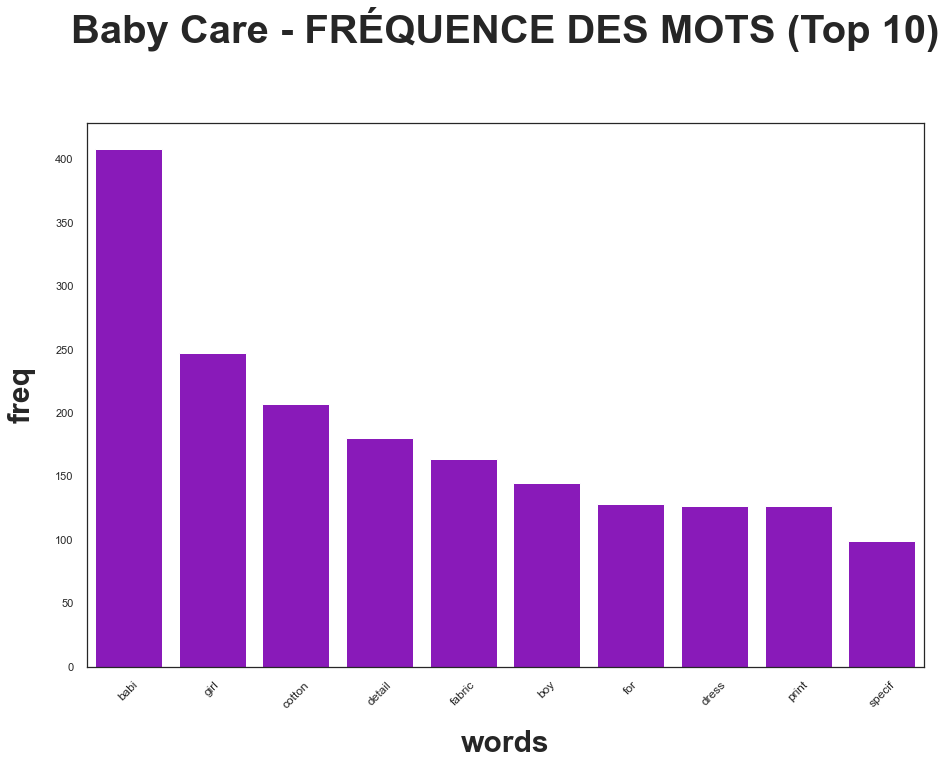

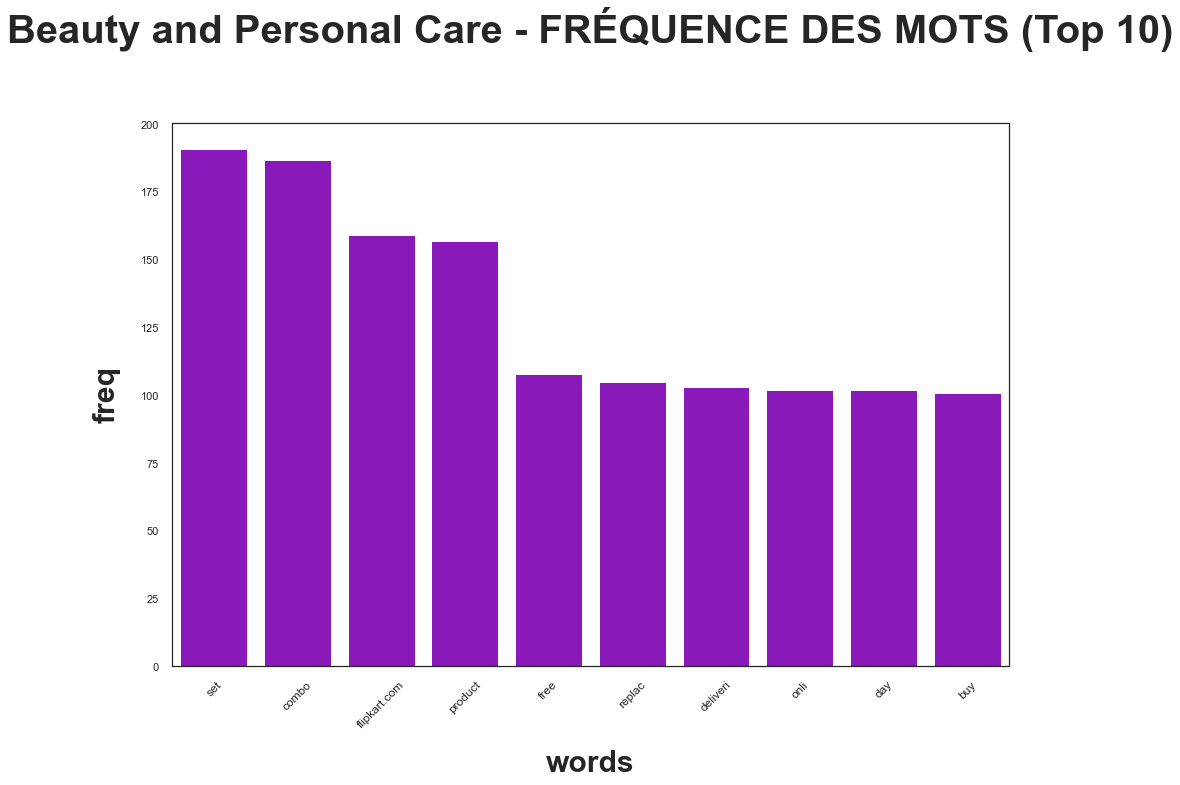

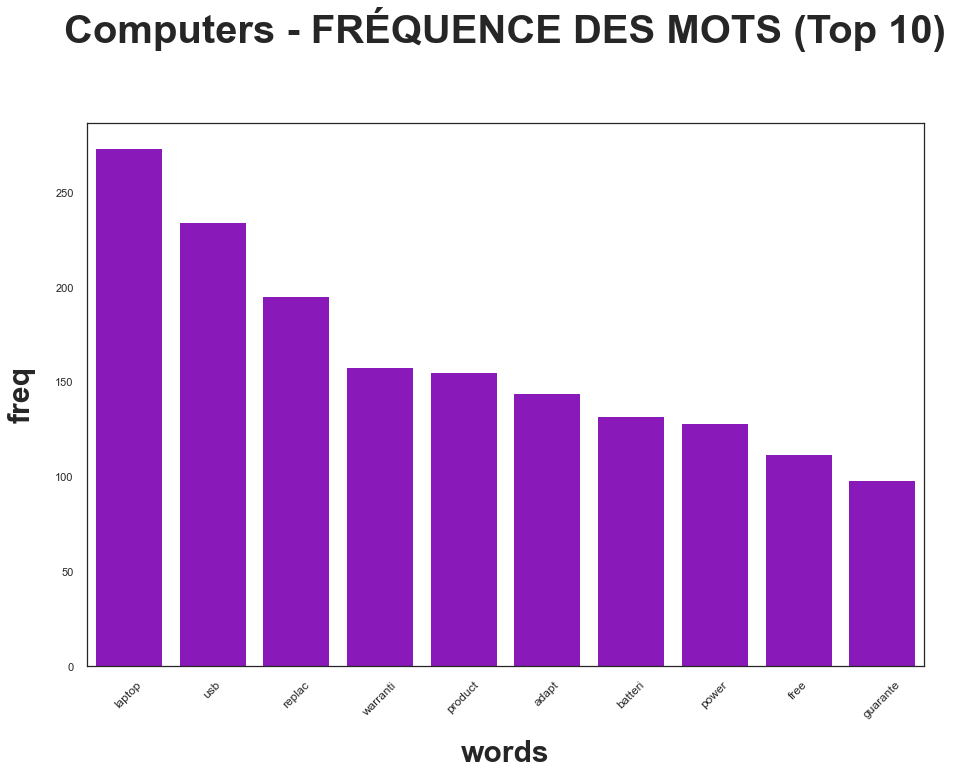

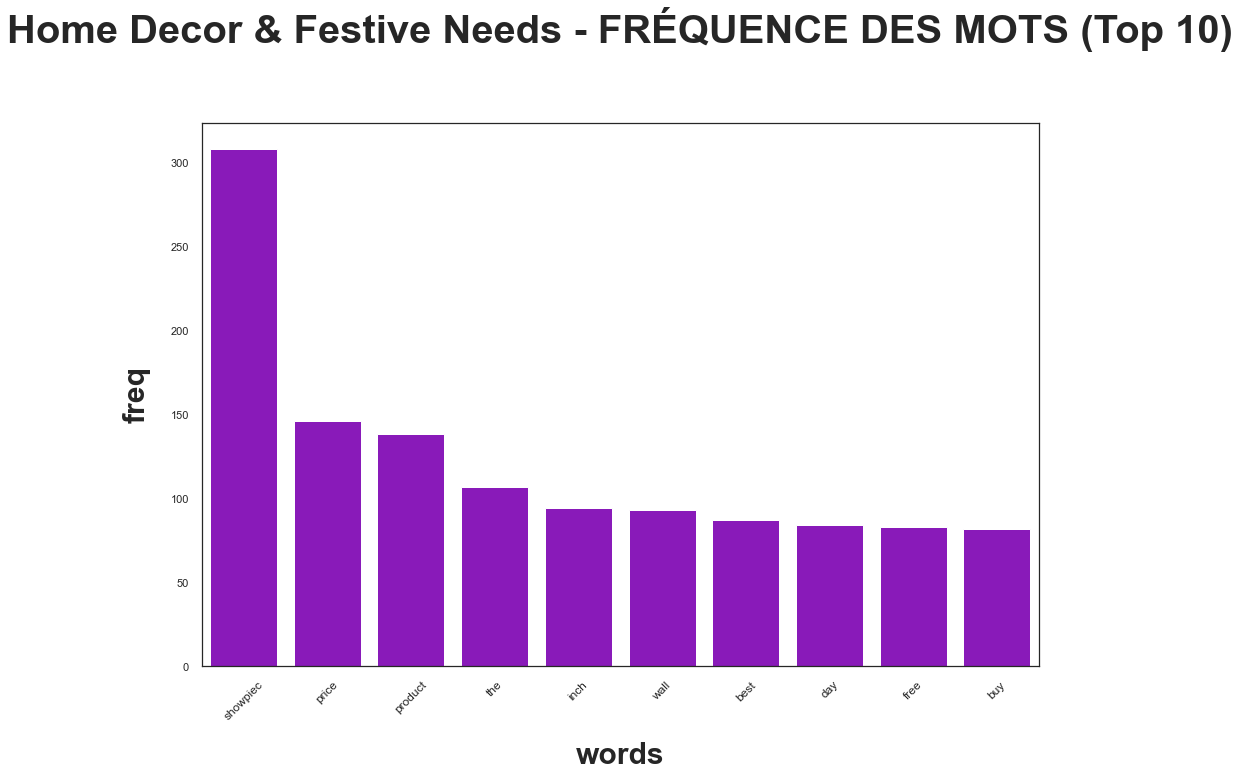

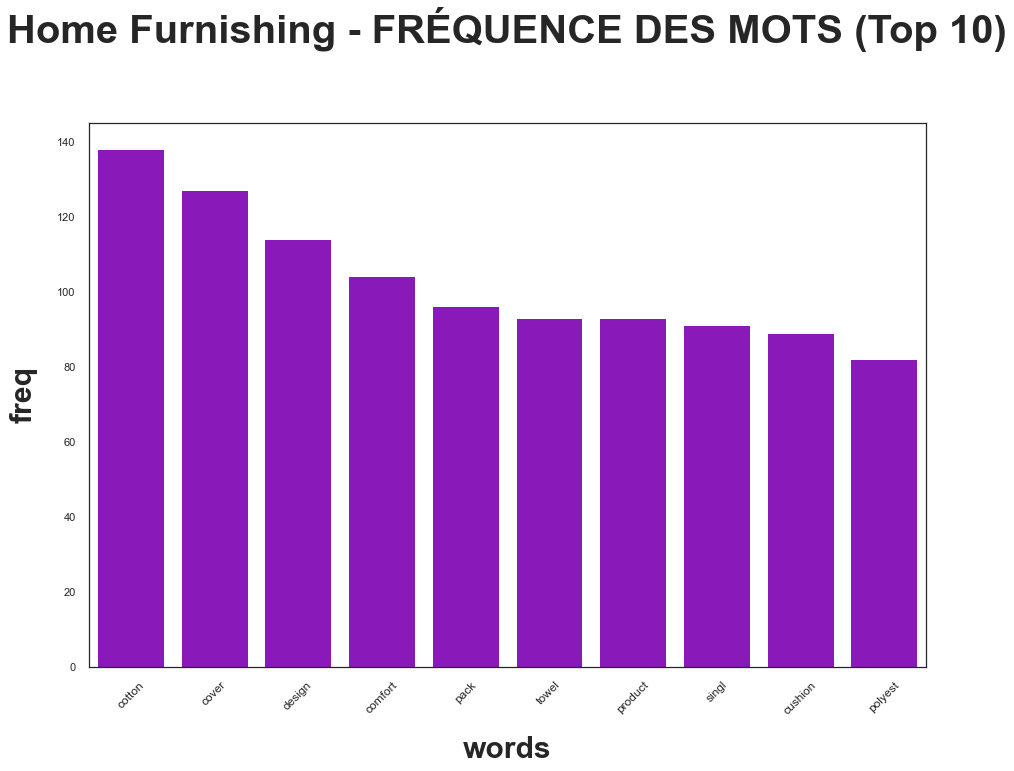

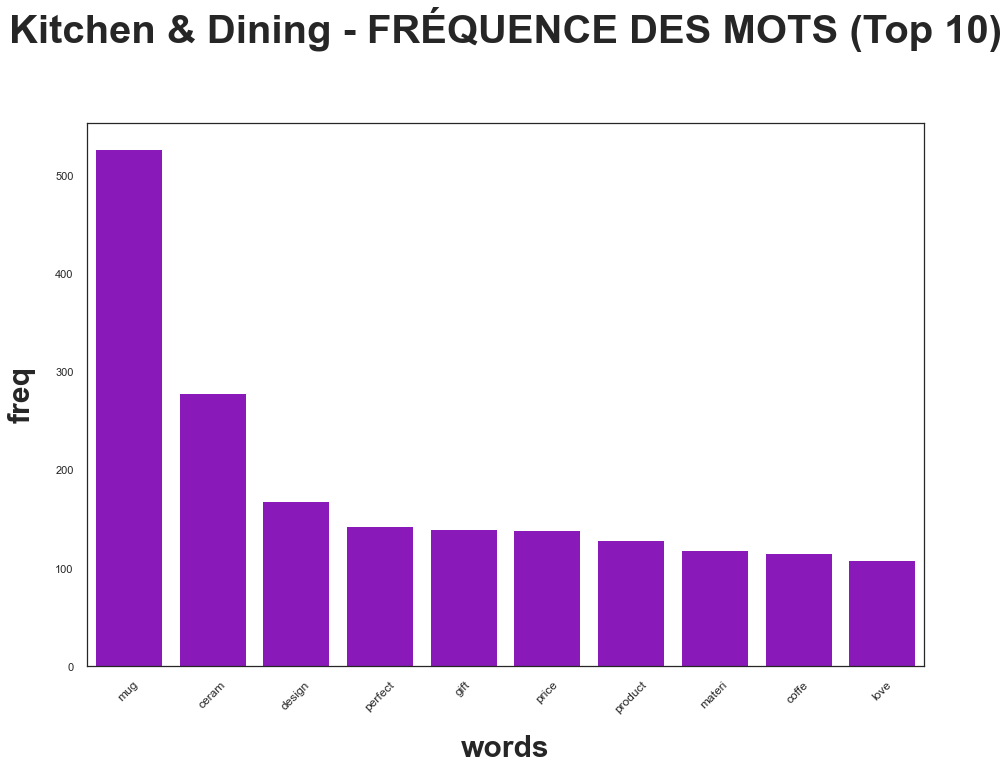

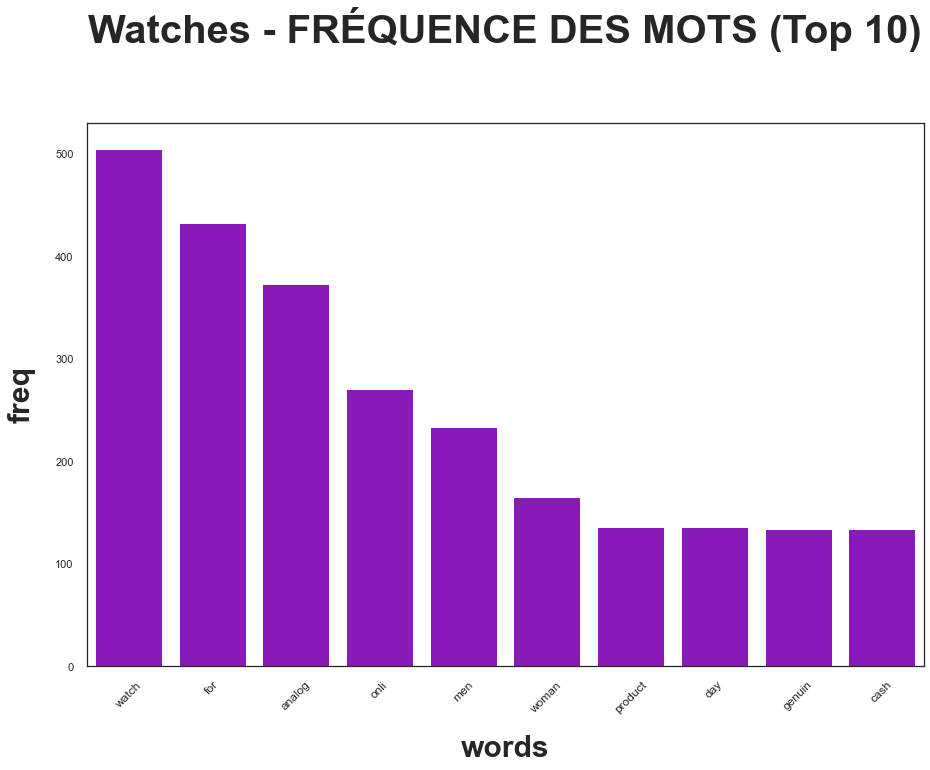

In [45]:
dfs_freq = pd.DataFrame()

for cat1, data_df in df_txt.groupby("category_0"):
    df_freq = freq(data_df["lem_words"], 10).reset_index()
    df_freq["Category"] = cat1
    dfs_freq= pd.concat([dfs_freq, df_freq])
    plot_freq_dist(df_freq, cat1 + " - FRÉQUENCE DES MOTS (Top 10)", 15, 10)

 ### Features à créer à partir du description :
 
Chaque modèle a des requisites différents :

- sentence_bow : descriptions en minuscule, sans mots inutiles, mais pas lemmatizés pour BOW (Bag-of-Words) et TF-IDF (term frequency-inverse document frequency)


On utilisera ces 'bag-of-words' pour les 'baseline' model


- sentence_bow_lem : traitement de sentence_bow, lemmatizés pour BOW, TF-IDF et Word2Vec
- sentence_dl : descriptions nettoyées

## conversion des mots en vecteurs de features


Nous allons extraire les features en utilisant les méthodes suivantes:

- Bag of Words (BOW)
- Term Frequency - Inverse Document Frequency (TF-IDF)

Nous allons comparer les résultats obtenus avec chacune de ces transformations.


### Transformation en matrice BOW

La méthode BOW consiste à créer un dataframe avec des colonnes pour chaque mot différent présent dans le corpus et d'indiquer le nombre de fois qu'il apparait dans chaque description de chaque article. Donc, nous créons un histogramme de l'apparition des mots dans l'ensemble des descriptions.

In [46]:
bow = CountVectorizer()
bow_vect = bow.fit_transform(df_txt['clean_text']).toarray()
bow_vect.shape

(1050, 4235)

In [47]:
# Dataframe in BOW 
bow_ft = bow.get_feature_names()
bow_df = pd.DataFrame(bow_vect , columns=bow_ft)
print(bow_df.shape)


(1050, 4235)


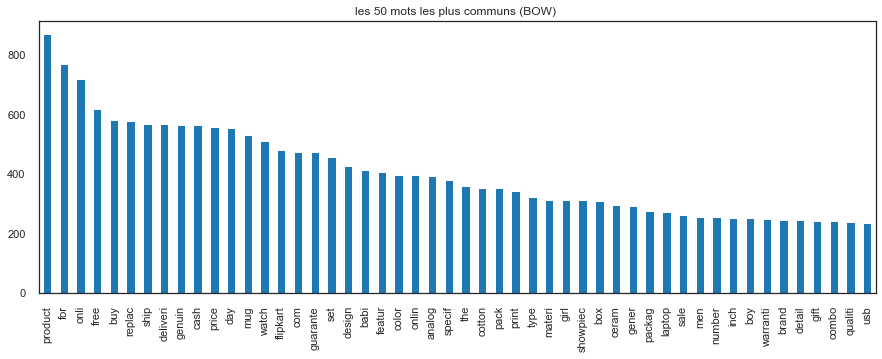

In [48]:
plt.title('les 50 mots les plus communs (BOW) ')
bow_df.sum(axis=0).sort_values(ascending=False)[:50].plot.bar(figsize=(15,5))
plt.show()

### Transformation en matrice TF-IDF

Le Term frequency-inverse document frequency (TF-IDF) est un modèle qui pondère les mots compte par une mesure de la fréquence à laquelle elles apparaissent dans le corpus. Il s'agit d'un statistique numérique destiné à refléter l'importance d'un mot ; c'est comme un facteur de pondération.

La valeur TF-IDF augmente proportionnellement au nombre de fois qu'un mot apparaît dans le corpus et est compensée par le nombre de documents dans le corpus qui contiennent le mot, ce qui permet d'ajuster le fait que certains mots apparaissent plus fréquemment en général.

In [49]:

tfidf = TfidfVectorizer()
tfidf_vect = tfidf.fit_transform(df_txt['clean_text']).toarray()
tfidf_vect.shape

(1050, 4235)

In [50]:
# Dataframe in TF-IDF form
tokens = tfidf.get_feature_names()
tfidf_df = pd.DataFrame(tfidf_vect, columns=tokens)
print(tfidf_df.shape)


(1050, 4235)


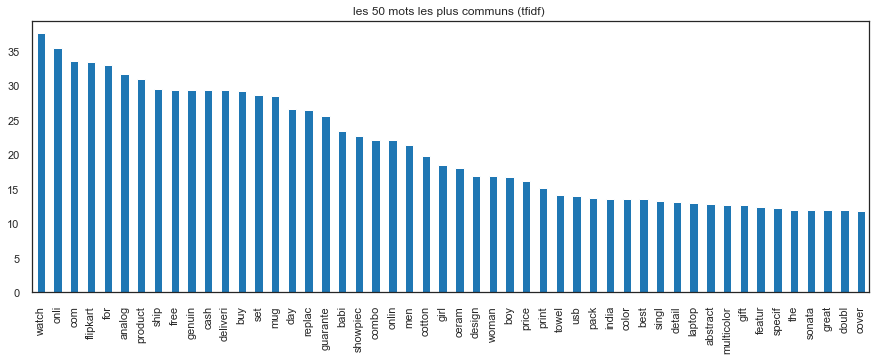

In [51]:
plt.title('les 50 mots les plus communs (tfidf) ')
tfidf_df.sum(axis=0).sort_values(ascending=False)[:50].plot.bar(figsize=(15,5))
plt.show()

### REDUCTION DE DIMENSION

Nous allons utiliser 2 techniques :

- Analyse en Composantes Principales (ACP)
- t-distributed stochastic neighbor embedding (t-SNE)

- **PCA**


La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99% dans notre cas)

**BOW**

In [52]:
print("Dimensions dataset avant réduction PCA : ", bow_vect.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_bow= pca.fit_transform(bow_vect)
print("Dimensions dataset après réduction PCA : ", pca_results_bow.shape)

Dimensions dataset avant réduction PCA :  (1050, 4235)
Dimensions dataset après réduction PCA :  (1050, 666)


**TF-IDF**

In [53]:

print("Dimensions dataset avant réduction PCA : ", tfidf_vect.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_tfidf= pca.fit_transform(tfidf_vect)
print("Dimensions dataset après réduction PCA : ", pca_results_tfidf.shape)

Dimensions dataset avant réduction PCA :  (1050, 4235)
Dimensions dataset après réduction PCA :  (1050, 821)


### TSNE


Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des textes


**BOW**

In [54]:

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_bow = tsne.fit_transform(pca_results_bow)

df_tsne_bow = pd.DataFrame(tsne_results_bow[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bow["class"] = df_txt["category_0"]
print(df_tsne_bow.shape)

(1050, 3)


 - **Visualisation**
 
 
Affichage T-SNE selon les catégories d'images


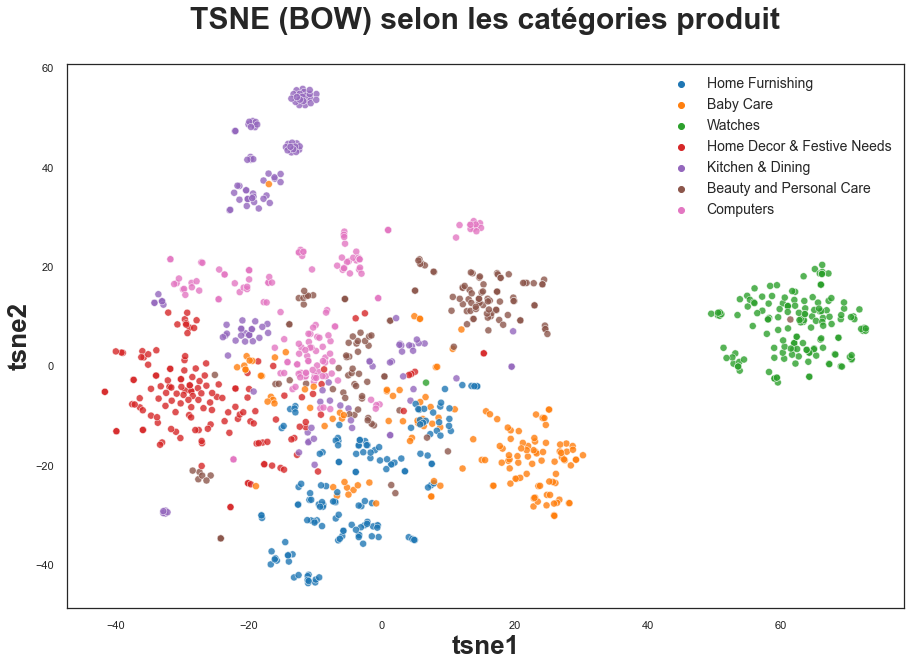

In [55]:


plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_bow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BOW) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

**TF-IDF**

In [56]:

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_tfidf = tsne.fit_transform(pca_results_tfidf)

df_tsne_tfidf = pd.DataFrame(tsne_results_tfidf[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_tfidf["class"] = df_txt["category_0"]
print(df_tsne_tfidf.shape)

(1050, 3)


 - **Visualisation**
 
 
Affichage T-SNE selon les catégories d'images


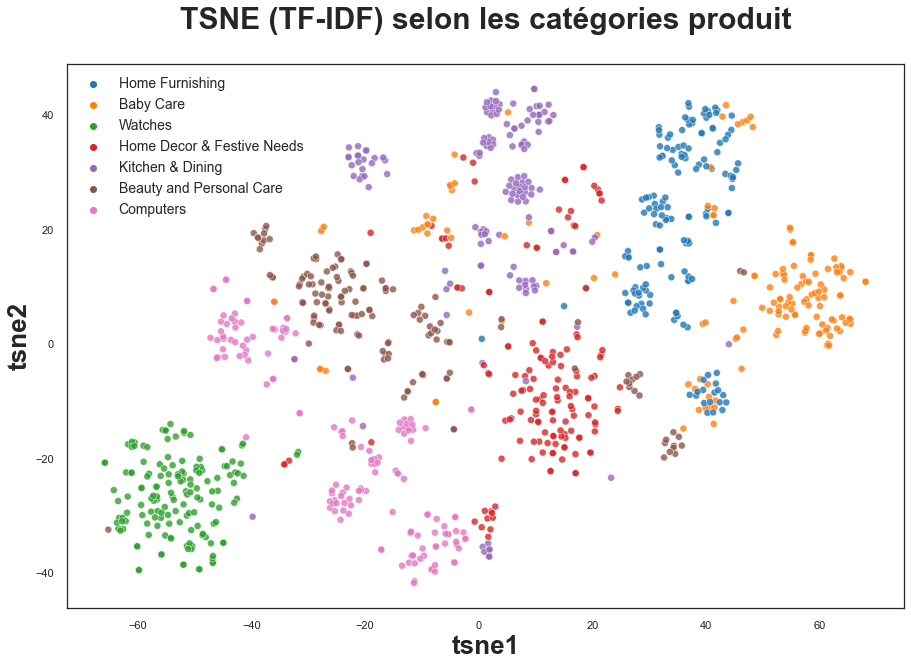

In [57]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_tfidf, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (TF-IDF) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


## CLUSTERING

In [58]:
df_resultats = pd.DataFrame()

def add_model_score(df: pd.DataFrame = None, model_name: str = 'none', ARI: float = 0, **kwargs):
    global df_resultats
    if df is None:
        df = df_resultats
    """ajout les resultats d'un model """
    resultats = dict(model=model_name, ARI=ARI)
    resultats = dict(**resultats, **kwargs)
    df = df.append(resultats, ignore_index=True)
    return df




In [60]:
N_CLUSTERS = 7 # On a 7 catégories produit

- **BOW**

In [61]:
#Création de clusters à partir du T-SNE 
X = df_tsne_bow[["tsne1","tsne2"]]

cls = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls.fit(X)

df_tsne_bow["cluster"] = cls.labels_

sil = silhouette_score(X,cls.labels_,metric="euclidean")
print("---------------------------")
print("Le score de silhouette est",round( sil,2))
print("---------------------------")

---------------------------
Le score de silhouette est 0.48
---------------------------


#### Calcul du Score ARI

Pour mesurer l'erreur de notre moteur de classification, nous allons utiliser la métrique ARI via la fonction
**adjusted_rand_score** de sklearn.


L'adjusted_rand_score calcule une mesure de similarité entre deux groupements en considérant toutes les paires d'échantillons
et en comptant les paires qui sont assignées dans le même groupement ou dans des groupements différents dans les groupements prédits et réels.


Le score ARI va de 0 pour un étiquetage aléatoire à 1 pour un étiquetage parfait.

In [62]:
# Création des labels à partir du nom de catégorie produit
le = preprocessing.LabelEncoder()
df_txt["label"] = le.fit_transform(df_txt["category_0"])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


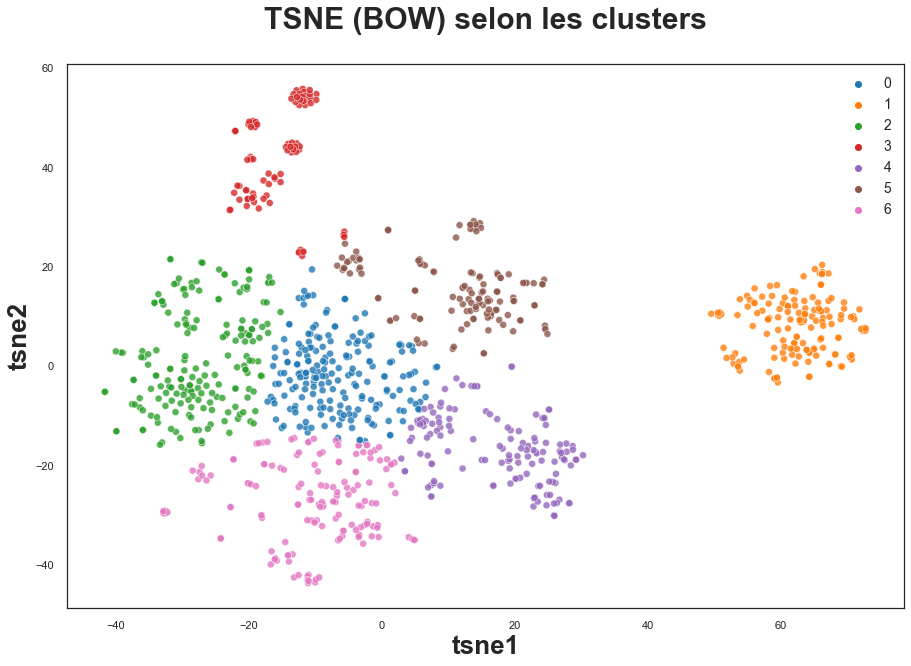

ARI  :  0.41886457622385787


In [63]:
#Affichage des images selon clusters et calcul ARI de similarité catégories produit / clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_bow,
    legend="brief")

plt.title('TSNE (BOW) selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_txt["label"]
print("ARI  : ", metrics.adjusted_rand_score(labels, cls.labels_))

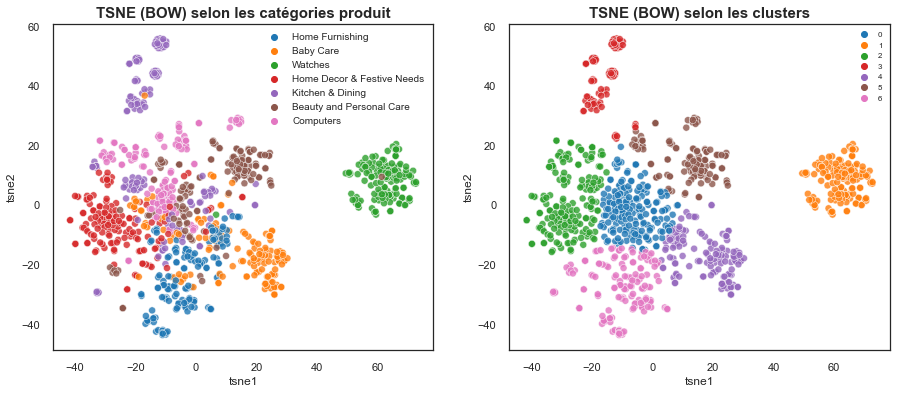

---------------------------
ARI :  0.419
---------------------------


In [64]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_bow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BOW) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
data=df_tsne_bow,
legend="brief")

plt.title('TSNE (BOW) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()
ARI_bow=round( metrics.adjusted_rand_score(labels, cls.labels_),3)
labels = df_txt["label"]
print("---------------------------")
print(f"ARI : ",ARI_bow)
print("---------------------------")
df_resultats = add_model_score(
    model_name='BOW ', ARI=ARI_bow)

In [65]:
df_resultats

model  ARI
0  BOW  0.42

- **Qualité de la catégorisation**

**répartition des vraies catégories par cluster**

In [66]:

# Fonction pour afficher la répartition des vraies catégories par cluster

def plot_clust_vs_cat(ser_clust, ser_cat, data, figsize=(8,4),
                                  palette='tab10', ylim=(0,250),
                                  bboxtoanchor=None):
    
    # pivot = data.drop(columns=['description','image'])
    pivot = pd.DataFrame()
    pivot['label']=ser_clust
    pivot['category']=ser_cat
    pivot['count']=1
    pivot = pivot.groupby(by=['label','category']).count().unstack().fillna(0)
    pivot.columns=pivot.columns.droplevel()
    
    colors = sns.color_palette(palette, ser_clust.shape[0]).as_hex()
    pivot.plot.bar(width=0.8,stacked=True,legend=True,figsize=figsize,
                   color=colors, ec='k')

    row_data=data.shape[0]

    if ser_clust.nunique() > 15:
        font = 8 
    else : 
        font = 12

    for index, value in enumerate(ser_clust.value_counts().sort_index(ascending=True)):
        percentage = np.around(value/row_data*100,1)   
        plt.text(index-0.25, value+2, str(percentage)+' %',fontsize=font)

    plt.gca().set(ylim=ylim)
    plt.xticks(rotation=0) 

    plt.xlabel('Clusters',fontsize=14)
    plt.ylabel('Nombre de produits', fontsize=14)
    plt.title('Répartition des vraies catégories par cluster',
              fontweight='bold', fontsize=18)

    if bboxtoanchor is not None:
        plt.legend(bbox_to_anchor=bboxtoanchor)
        
    plt.show()    
    
    return pivot

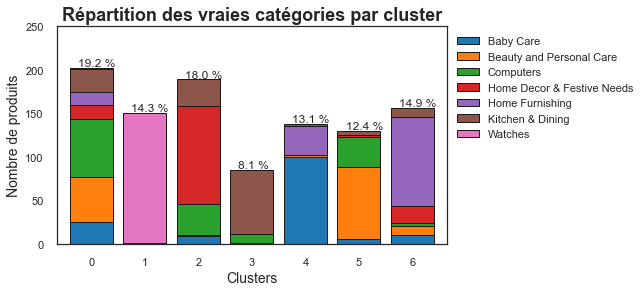

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0             25.00                     52.00      66.00   
1              0.00                      1.00       0.00   
2              9.00                      1.00      36.00   
3              1.00                      0.00      10.00   
4            100.00                      2.00       0.00   
5              5.00                     83.00      35.00   
6             10.00                     11.00       3.00   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                              17.00            14.00             27.00   
1                               0.00             0.00              0.00   
2                             112.00             0.00             31.00   
3                               0.00             0.00             74.00   
4                               0.00            33.00              3.00   
5                               2.00             0.00              5.00   
6                              19.00           103.00             10.00   

category  Watches  
label              
0            1.00  
1          149.00  
2            0.00  
3            0.00  
4            0.00  
5            0.00  
6            0.00

In [67]:
plot_clust_vs_cat(df_tsne_bow["cluster"],
                              df_tsne_bow["class"],
                              df_tsne_bow,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,250))

In [68]:
# Affiche la matrice de confusion

def confusion_matrix(y_true, y_pred, title):
    """ xxx
    Args:
        y_true list(str):
        y_pred list(int):
        title (str): 
    Returns:
        -
    """
    # Create a DataFrame with labels and varieties as columns: df
    df = pd.DataFrame({'Labels': y_true, 'Clusters': y_pred})

    # Create crosstab: ct
    ct = pd.crosstab(df['Labels'], df['Clusters'])

    # plot the heatmap for correlation matrix
    fig, ax = plt.subplots(figsize=(10, 8))

    sns.heatmap(ct.T, 
                 square=True, 
                 annot=True, 
                 annot_kws={"size": 17},
                 fmt='.2f',
                 cmap='Blues',
                 cbar=False,
                 ax=ax)

    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)
    ax.set_ylabel("clusters", fontsize=15)
    ax.set_xlabel("labels", fontsize=15)

    plt.show()


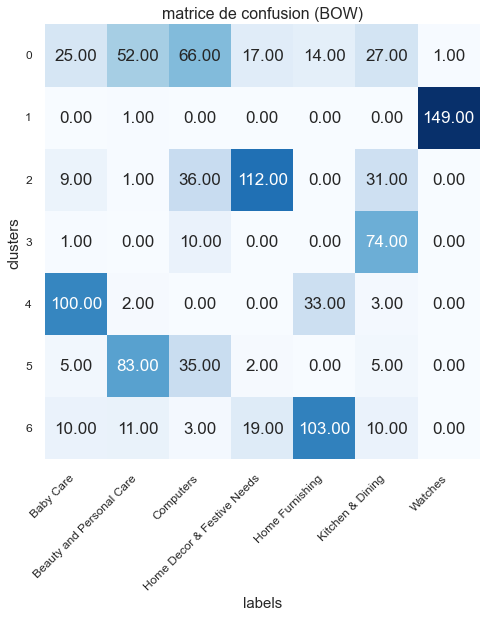

In [69]:
confusion_matrix(df_tsne_bow["class"], df_tsne_bow["cluster"], 'matrice de confusion (BOW)')

- **TF-IDF**

In [70]:

#Création de clusters à partir du T-SNE 
X = df_tsne_tfidf[["tsne1","tsne2"]]

cls_tfidf = KMeans(n_clusters=N_CLUSTERS, init='k-means++')
cls_tfidf.fit(X)

df_tsne_tfidf["cluster"] = cls_tfidf.labels_

sil = silhouette_score(X,cls_tfidf.labels_,metric="euclidean")
print("---------------------------")
print("Le score de silhouette est",round( sil,2))
print("---------------------------")

---------------------------
Le score de silhouette est 0.49
---------------------------


In [71]:
df_tsne_tfidf.head(2)

tsne1  tsne2            class  cluster
0  28.62   7.06  Home Furnishing        6
1  41.69  -9.84        Baby Care        3

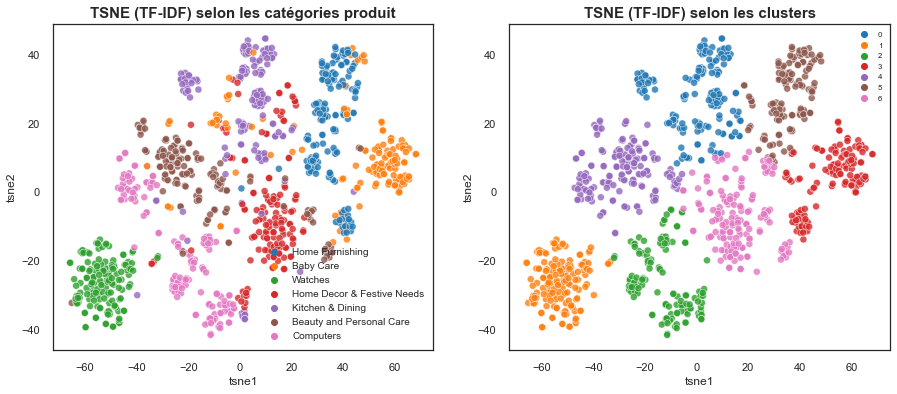

---------------------------
ARI :  0.542
---------------------------


In [72]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_tfidf, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (TF-IDF) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
data=df_tsne_tfidf,
legend="brief")

plt.title('TSNE (TF-IDF) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()
ARI_tf_idf=round( metrics.adjusted_rand_score(labels, cls_tfidf.labels_),3)
labels = df_txt["label"]
print("---------------------------")
print(f"ARI : ",ARI_tf_idf)
print("---------------------------")
df_resultats = add_model_score(
    model_name='TF-IDF ', ARI=ARI_tf_idf)

- **Qualité de la catégorisation**

**répartition des vraies catégories par cluster**

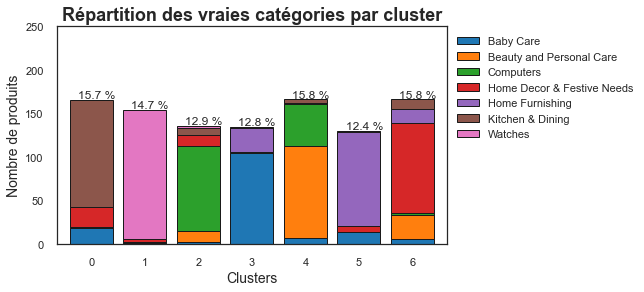

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0             18.00                      1.00       0.00   
1              0.00                      1.00       1.00   
2              2.00                     13.00      98.00   
3            104.00                      2.00       0.00   
4              7.00                    105.00      49.00   
5             14.00                      0.00       0.00   
6              5.00                     28.00       2.00   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                              23.00             0.00            123.00   
1                               3.00             0.00              1.00   
2                              12.00             0.00              8.00   
3                               0.00            27.00              1.00   
4                               1.00             0.00              4.00   
5                               7.00           107.00              2.00   
6                             104.00            16.00             11.00   

category  Watches  
label              
0            0.00  
1          148.00  
2            2.00  
3            0.00  
4            0.00  
5            0.00  
6            0.00

In [73]:
plot_clust_vs_cat(df_tsne_tfidf["cluster"],
                              df_tsne_tfidf["class"],
                              df_tsne_tfidf,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,250))

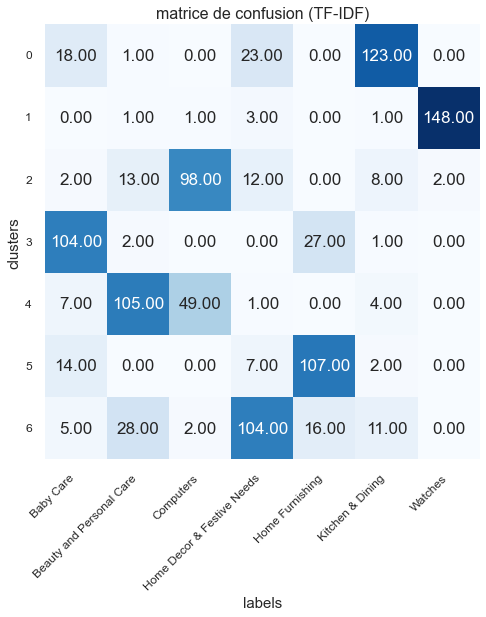

In [74]:
confusion_matrix(df_tsne_tfidf["class"], df_tsne_tfidf["cluster"], 'matrice de confusion (TF-IDF)')

 ### modèle 2: Word2Vec embedding

**Méthode Word2Vec**


Word2vec est un groupe de modèles utilisé pour le plongement lexical (word embedding). Ces modèles ont été développés par une équipe de recherche chez Google sous la direction de Tomas Mikolov. Ce sont des réseaux de neurones artificiels à deux couches entraînés pour reconstruire le contexte linguistique des mots. La méthode est implémentée dans la bibliothèque Python Gensim.

In [75]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df_txt['clean_text'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [76]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4225
Word2Vec trained


In [77]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4226


- **Création de la matrice d'embedding**

In [78]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4226, 300)


In [79]:
def creer_vecteur_moyen_par_mot(data, text_dim, w2v_model):

    vect_moy = np.zeros((text_dim,), dtype='float32')
    num_words = 0.

    for word in data.split():
        if word in w2v_model.wv.vocab:
            vect_moy = np.add(vect_moy, w2v_model[word])
            num_words += 1.

    if num_words != 0.:
        vect_moy = np.divide(vect_moy, num_words)

    return vect_moy

- **Création du modèle d'embedding**

In [80]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1267800   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,267,800
Trainable params: 1,267,800
Non-trainable params: 0
_________________________________________________________________


- **Exécution du modèle**

In [81]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 4ms/step


(1050, 300)

#### REDUCTION DE DIMENSION

- **ACP**

In [82]:
print("Dimensions dataset avant réduction PCA : ", embeddings.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_word2vec= pca.fit_transform(embeddings)
print("Dimensions dataset après réduction PCA : ", pca_results_word2vec.shape)

Dimensions dataset avant réduction PCA :  (1050, 300)
Dimensions dataset après réduction PCA :  (1050, 62)


- **T_SNE**

In [83]:

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_word2vec = tsne.fit_transform(pca_results_word2vec)

df_tsne_word2vec = pd.DataFrame(tsne_results_word2vec[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_word2vec["class"] = df_txt["category_0"]

print(df_tsne_word2vec.shape)

(1050, 3)


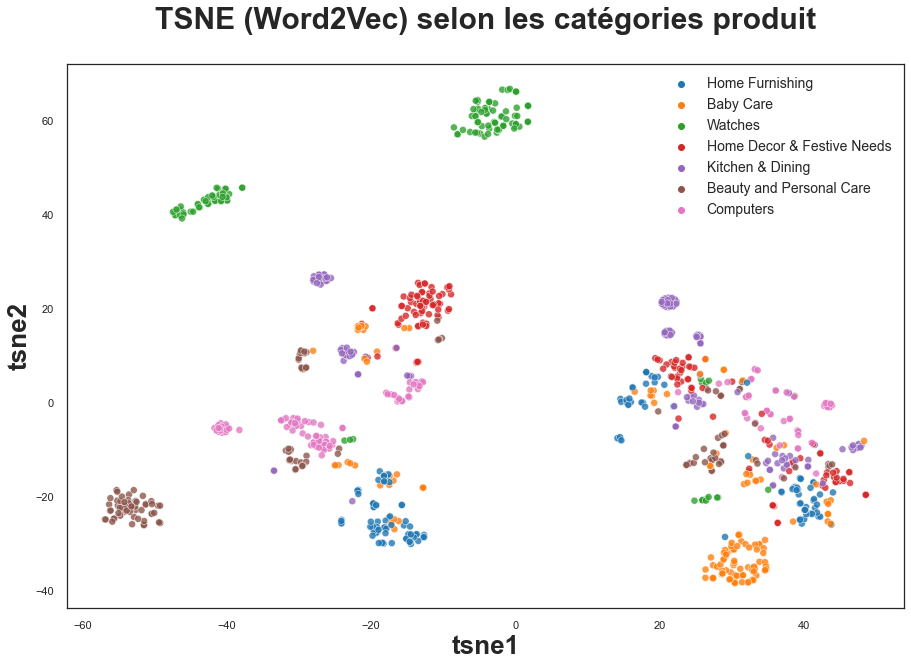

In [84]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_word2vec, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (Word2Vec) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [85]:
#Création de clusters à partir du T-SNE 
X = df_tsne_word2vec[["tsne1","tsne2"]]

cls_Word2Vec = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls_Word2Vec.fit(X)

df_tsne_word2vec["cluster"] = cls_Word2Vec.labels_

sil = np.round(silhouette_score(X,cls_Word2Vec.labels_,metric="euclidean"),2)
print("---------------------------")
print("Le score de silhouette est", sil)
print("---------------------------")

---------------------------
Le score de silhouette est 0.58
---------------------------


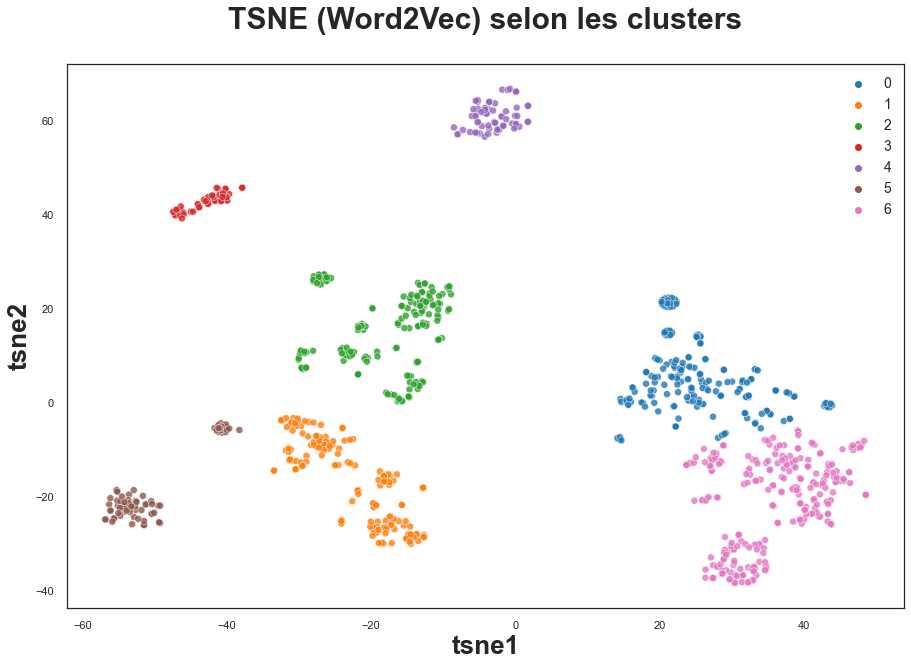

---------------------------
ARI :  0.182
---------------------------


In [86]:
#Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_word2vec,
    legend="brief")

plt.title('TSNE (Word2Vec) selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()
ARI_Word2Vec=np.round(metrics.adjusted_rand_score(labels, cls_Word2Vec.labels_),3)
labels = df_txt["label"]
print("---------------------------")
print("ARI : ",ARI_Word2Vec)
print("---------------------------")


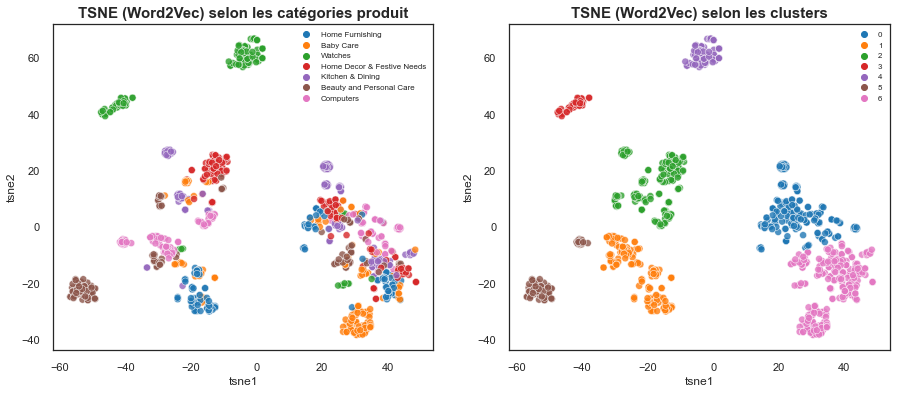

---------------------------
ARI :  0.182
---------------------------


In [87]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_word2vec, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (Word2Vec) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 


ax = fig.add_subplot(122)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_word2vec,
    legend="brief")

plt.title('TSNE (Word2Vec) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()


ARI_Word2Vec=np.round(metrics.adjusted_rand_score(labels, cls_Word2Vec.labels_),3)

print("---------------------------")
print("ARI : ",ARI_Word2Vec)
print("---------------------------")
df_resultats = add_model_score(
    model_name='Word2Vec ', ARI=ARI_Word2Vec)

In [88]:
df_tsne_word2vec.groupby("cluster").count()["class"]

cluster
0    209
1    176
2    183
3     51
4     80
5     79
6    272
Name: class, dtype: int64

- **Qualité de la catégorisation**

**répartition des vraies catégories par cluster**

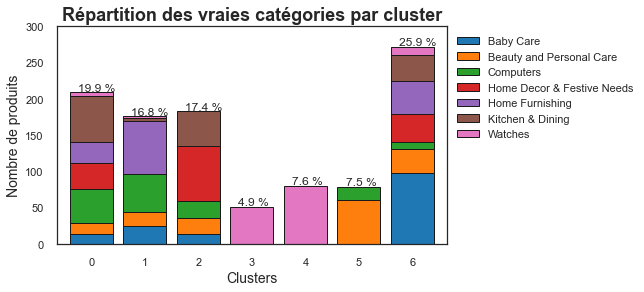

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0             13.00                     16.00      46.00   
1             25.00                     19.00      52.00   
2             14.00                     21.00      24.00   
3              0.00                      0.00       0.00   
4              0.00                      0.00       0.00   
5              0.00                     61.00      18.00   
6             98.00                     33.00      10.00   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                              36.00            30.00             63.00   
1                               0.00            74.00              3.00   
2                              76.00             0.00             48.00   
3                               0.00             0.00              0.00   
4                               0.00             0.00              0.00   
5                               0.00             0.00              0.00   
6                              38.00            46.00             36.00   

category  Watches  
label              
0            5.00  
1            3.00  
2            0.00  
3           51.00  
4           80.00  
5            0.00  
6           11.00

In [89]:
plot_clust_vs_cat(df_tsne_word2vec["cluster"],
                              df_tsne_word2vec["class"],
                              df_tsne_word2vec,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

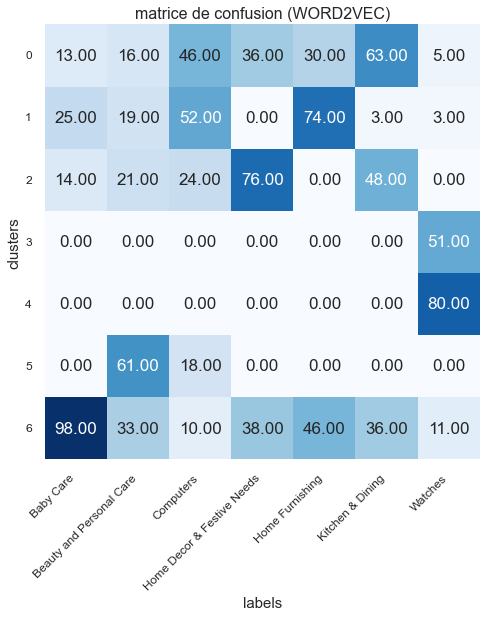

In [90]:
confusion_matrix(df_tsne_word2vec['class'], df_tsne_word2vec['cluster'], 'matrice de confusion (WORD2VEC)')

### BERT

### Création de feature sentence_dl pour deep learning


Les modèles de deep learning comme BERT et USE traitent les mots dans le contexte de leurs phrases

- BERT : Bidirectional Encoder Representations from Transformers
- USE : Universal Sentence Encoder


Avec BERT et USE, il ne faut pas trop traiter les textes, sinon, on perdre le contexte (racine, lemmatisation) ou modifier purement et simplement les textes (suppression des mots vides).

Les descriptions des produits semblent déjà traités, donc on essaie d'eviter de supprimer les stopwords et lemmatization.

In [92]:
# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    lw = lower_start_fct(desc_text)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [93]:
df_txt['sentence_dl'] = df_txt['net_tokens'].apply(lambda x : transform_dl_fct(x))
df_txt.head(3)

category_0  \
0  Home Furnishing   
1        Baby Care   
2        Baby Care   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   
2                         Eurospa Cotton Terry Face Towel Set   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   

                                                                                             name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   
2  Eurospa Cotton Terry Face Towel Set Key Features of Eurospa Cotton Terry Face Towel Set Size: sm...   

                                                                                           remove_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel ( Bath Towel, Red, Yello...   
2  Eurospa Cotton Terry Face Towel Set Key Features of Eurospa Cotton Terry Face Towel Set Size: sm...   

                                                                                           remove_emoj  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Mu...   
1  Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yell...   
2  Eurospa Cotton Terry Face Towel Set Key Features of Eurospa Cotton Terry Face Towel Set Size: sm...   

                                                                                                tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...   
2  [Eurospa, Cotton, Terry, Face, Towel, Set, Key, Features, Eurospa, Cotton, Terry, Face, Towel, S...   

                                                                                            net_tokens  \
0  [Elegance, Polyester, Multicolor, Abstract, Eyelet, Door, Curtain, Key, Features, Elegance, Poly...   
1  [Sathiyas, Cotton, Bath, Towel, Specifications, Sathiyas, Cotton, Bath, Towel, Bath, Towel, Red,...   
2  [Eurospa, Cotton, Terry, Face, Towel, Set, Key, Features, Eurospa, Cotton, Terry, Face, Towel, S...   

                                                                                            stem_words  \
0  [eleg, polyest, multicolor, abstract, eyelet, door, curtain, key, featur, eleg, polyest, multico...   
1  [sathiya, cotton, bath, towel, specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, b...   
2  [eurospa, cotton, terri, face, towel, set, key, featur, eurospa, cotton, terri, face, towel, set...   

                                                                                             lem_words  \
0  [eleg, polyest, multicolor, abstract, eyelet, door, curtain, key, featur, eleg, polyest, multico...   
1  [sathiya, cotton, bath, towel, specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, b...   
2  [eurospa, cotton, terri, face, towel, set, key, featur, eurospa, cotton, terri, face, towel, set...   

                                                                                            clean_text  \
0  eleg polyest multicolor abstract eyelet door curtain key featur eleg polyest multicolor abstract...   
1  sathiya cotton bath towel specif sathiya co

In [94]:

df_bert_use=df_txt[['category_0','sentence_dl']].copy()
df_bert_use.head(2)

category_0  \
0  Home Furnishing   
1        Baby Care   

                                                                                           sentence_dl  
0  elegance polyester multicolor abstract eyelet door curtain key features elegance polyester multi...  
1  sathiyas cotton bath towel specifications sathiyas cotton bath towel bath towel red yellow blue ...

In [95]:
df_bert_use['length_dl'] = df_bert_use['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df_bert_use['length_dl'].max())


max length dl :  378


In [96]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

- **BERT HuggingFace**

- Model 'bert-base-uncased'

In [97]:
# from transformers import TFAutoModel

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)
sentences = df_bert_use['sentence_dl'].to_list()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [98]:
from transformers import AutoTokenizer
# Création des features
# downloads bert features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 4s 4s/step
temps traitement :  438.0


In [99]:
features_bert.shape

(1050, 768)

#### REDUCTION DE DIMENSION

- **ACP**

In [100]:
print("Dimensions dataset avant réduction PCA : ", features_bert.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_bert= pca.fit_transform(features_bert)
print("Dimensions dataset après réduction PCA : ", pca_results_bert.shape)


Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 339)


- **T_SNE**

In [101]:

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_bert = tsne.fit_transform(pca_results_bert)

df_tsne_bert = pd.DataFrame(tsne_results_bert[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bert["class"] = df_txt["category_0"]
print(df_tsne_bert.shape)

(1050, 3)


 - **Visualisation**
 
 
Affichage T-SNE selon les catégories d'images


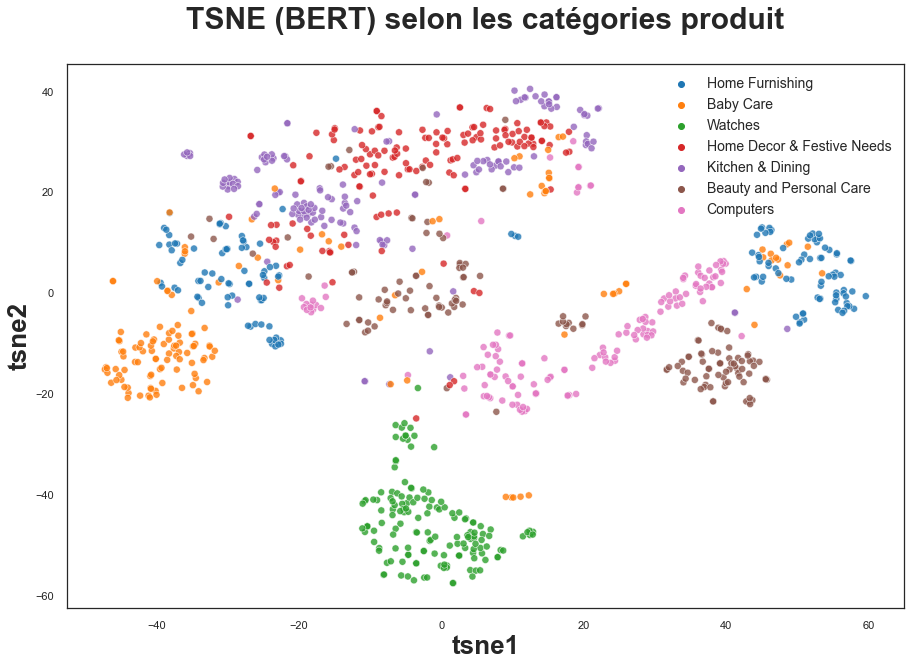

In [102]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_bert, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BERT) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


In [103]:
#Création de clusters à partir du T-SNE 
X = df_tsne_bert[["tsne1","tsne2"]]

cls_bert = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls_bert.fit(X)

df_tsne_bert["cluster"] = cls_bert.labels_

sil = np.round(silhouette_score(X,cls_bert.labels_,metric="euclidean"),2)
print("---------------------------")
print("Le score de silhouette est", sil)
print("---------------------------")

---------------------------
Le score de silhouette est 0.49
---------------------------


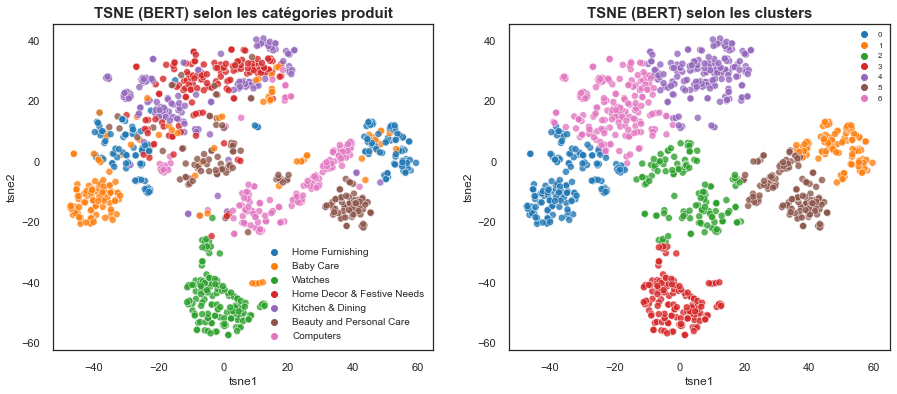

---------------------------
ARI :  0.375
---------------------------


In [104]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_bert, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BERT) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
data=df_tsne_bert,legend="brief")

plt.title('TSNE (BERT) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()
ARI_bert1 =round( metrics.adjusted_rand_score(labels, cls_bert.labels_),3)
labels = df_txt["label"]
print("---------------------------")
print(f"ARI : ",ARI_bert1 )
print("---------------------------")
df_resultats = add_model_score(
    model_name='BERT (bert-base-uncased) ', ARI=ARI_bert1 )

In [105]:
df_tsne_bert.groupby("cluster").count()["class"]

cluster
0    158
1    106
2    133
3    150
4    178
5    133
6    192
Name: class, dtype: int64

- **Qualité de la catégorisation**

- **répartition des vraies catégories par cluster**

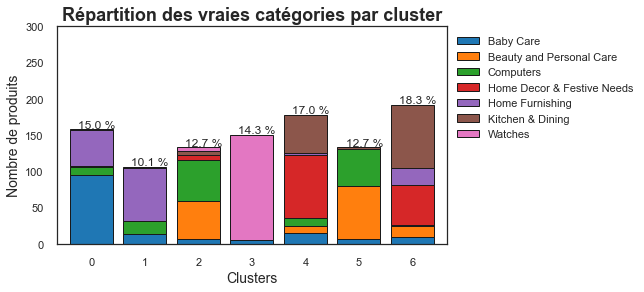

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0             95.00                      0.00      11.00   
1             13.00                      0.00      18.00   
2              6.00                     53.00      57.00   
3              5.00                      0.00       0.00   
4             15.00                      9.00      11.00   
5              7.00                     73.00      51.00   
6              9.00                     15.00       2.00   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                               2.00            49.00              1.00   
1                               0.00            74.00              1.00   
2                               6.00             0.00              6.00   
3                               0.00             0.00              0.00   
4                              87.00             3.00             53.00   
5                               0.00             0.00              2.00   
6                              55.00            24.00             87.00   

category  Watches  
label              
0            0.00  
1            0.00  
2            5.00  
3          145.00  
4            0.00  
5            0.00  
6            0.00

In [106]:
plot_clust_vs_cat(df_tsne_bert["cluster"],
                              df_tsne_bert["class"],
                              df_tsne_bert,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

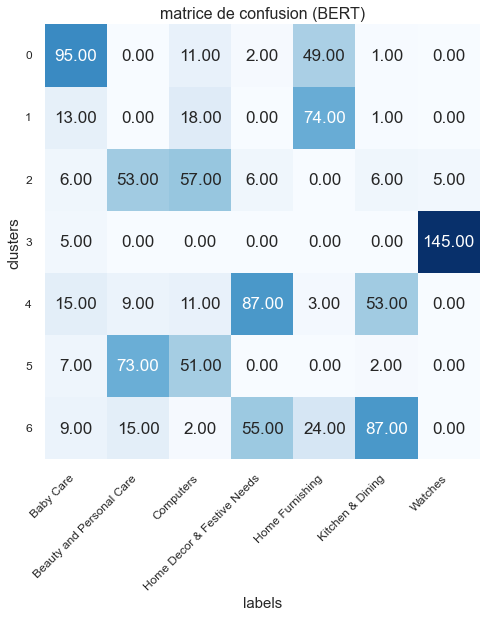

In [107]:
confusion_matrix(df_tsne_bert["class"], df_tsne_bert["cluster"], 'matrice de confusion (BERT)')

- **BERT hub Tensorflow**

In [108]:
# import tensorflow_hub as hub


# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# downloads 500Mb de model
small_model_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = tensorflow_hub.KerasLayer(model_url, trainable=True)


In [109]:
sentences = df_bert_use['sentence_dl'].to_list()
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer


In [110]:
features_bert_hub_Tensorflow, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  387.0


#### REDUCTION DE DIMENSION

- **ACP**

In [111]:
print("Dimensions dataset avant réduction PCA : ", features_bert_hub_Tensorflow.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_bert_hub_Tensorflow= pca.fit_transform(features_bert_hub_Tensorflow)
print("Dimensions dataset après réduction PCA : ", pca_results_bert_hub_Tensorflow.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 339)


- **T_SNE**

In [112]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_bert_hub_Tensorflow = tsne.fit_transform(pca_results_bert_hub_Tensorflow)

df_tsne_bert_hub_Tensorflow = pd.DataFrame(tsne_results_bert_hub_Tensorflow[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bert_hub_Tensorflow["class"] = df_txt["category_0"]
print(df_tsne_bert_hub_Tensorflow.shape)

(1050, 3)


 - **Visualisation**
 
 
Affichage T-SNE selon les catégories d'images


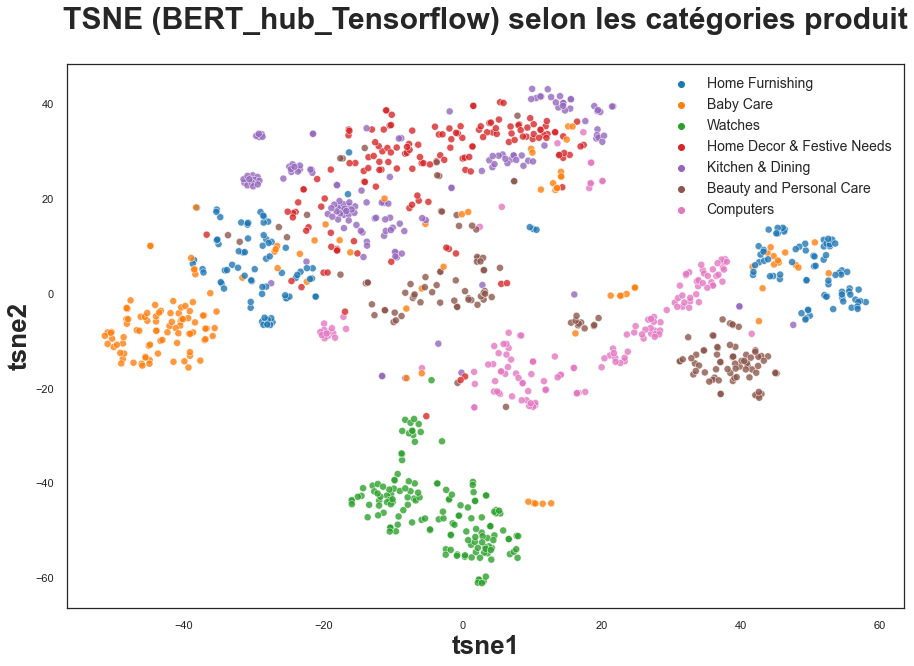

In [113]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_bert_hub_Tensorflow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BERT_hub_Tensorflow) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


In [115]:
#Création de clusters à partir du T-SNE 
X = df_tsne_bert_hub_Tensorflow[["tsne1","tsne2"]]

cls_bert3 = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls_bert3.fit(X)

df_tsne_bert_hub_Tensorflow["cluster"] = cls_bert3.labels_

sil = np.round(silhouette_score(X,cls_bert3.labels_,metric="euclidean"),2)
print("---------------------------")
print("Le score de silhouette est", sil)
print("---------------------------")

---------------------------
Le score de silhouette est 0.48
---------------------------


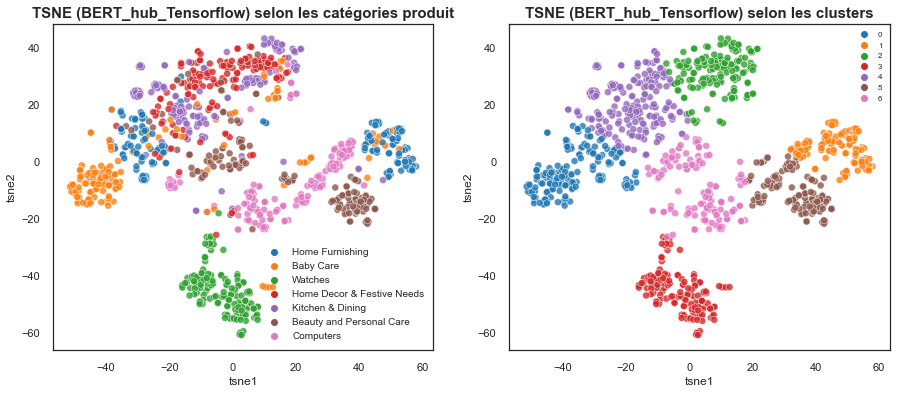

---------------------------
ARI :  0.369
---------------------------


In [116]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_bert_hub_Tensorflow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BERT_hub_Tensorflow) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8, data=df_tsne_bert_hub_Tensorflow,legend="brief")

plt.title('TSNE (BERT_hub_Tensorflow) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()

labels = df_txt["label"]
ARI_bert3=np.round(metrics.adjusted_rand_score(labels, cls_bert3.labels_),3)

print("---------------------------")
print(f"ARI : ",ARI_bert3)
print("---------------------------")
df_resultats = add_model_score(
    model_name='BERT(hub Tensorflow) ', ARI=ARI_bert3)

In [117]:
df_tsne_bert_hub_Tensorflow.groupby("cluster").count()["class"]

cluster
0    162
1    115
2    159
3    153
4    206
5    124
6    131
Name: class, dtype: int64

- **Qualité de la catégorisation**

- **répartition des vraies catégories par cluster**

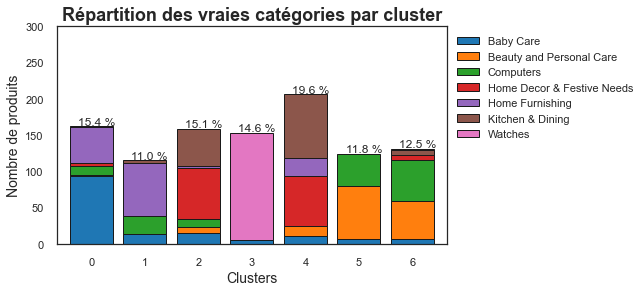

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0             93.00                      2.00      13.00   
1             13.00                      0.00      25.00   
2             15.00                      8.00      11.00   
3              5.00                      0.00       0.00   
4             11.00                     14.00       0.00   
5              7.00                     73.00      44.00   
6              6.00                     53.00      57.00   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                               4.00            49.00              1.00   
1                               0.00            74.00              3.00   
2                              71.00             3.00             51.00   
3                               0.00             0.00              0.00   
4                              69.00            24.00             88.00   
5                               0.00             0.00              0.00   
6                               6.00             0.00              7.00   

category  Watches  
label              
0            0.00  
1            0.00  
2            0.00  
3          148.00  
4            0.00  
5            0.00  
6            2.00

In [118]:
plot_clust_vs_cat(df_tsne_bert_hub_Tensorflow["cluster"],
                              df_tsne_bert_hub_Tensorflow["class"],
                              df_tsne_bert_hub_Tensorflow,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

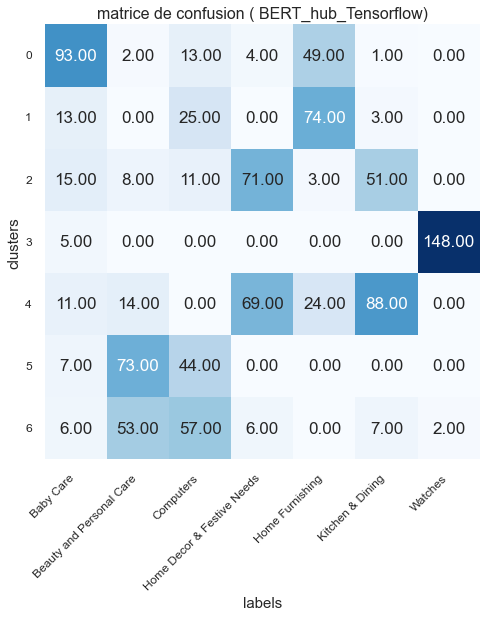

In [119]:
confusion_matrix( df_tsne_bert_hub_Tensorflow["class"],  df_tsne_bert_hub_Tensorflow["cluster"],
                 'matrice de confusion ( BERT_hub_Tensorflow)')

### USE - Universal Sentence Encoder

In [120]:
# import tensorflow_hub as hub
USE_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# 1Gb model
embed = tensorflow_hub.load(USE_model_url)


In [121]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    print(f'feature_USE_fct, time_taken = {time2} s')
    return features

In [122]:
batch_size = 10
sentences = df_bert_use['sentence_dl'].to_list()

In [123]:
df_USE = feature_USE_fct(sentences, batch_size)

feature_USE_fct, time_taken = 5.0 s


#### REDUCTION DE DIMENSION

- **ACP**

In [124]:
print("Dimensions dataset avant réduction PCA : ", df_USE.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_USE= pca.fit_transform(df_USE)
print("Dimensions dataset après réduction PCA : ", pca_results_USE.shape)

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 341)


- **Tsne**

In [125]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_bert_hub_Tensorflow = tsne.fit_transform(pca_results_USE)

df_tsne_results_USE = pd.DataFrame(tsne_results_bert_hub_Tensorflow [:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_results_USE["class"] = df_txt["category_0"]
print(df_tsne_results_USE.shape)

(1050, 3)


 - **Visualisation**
 
 
Affichage T-SNE selon les catégories d'images


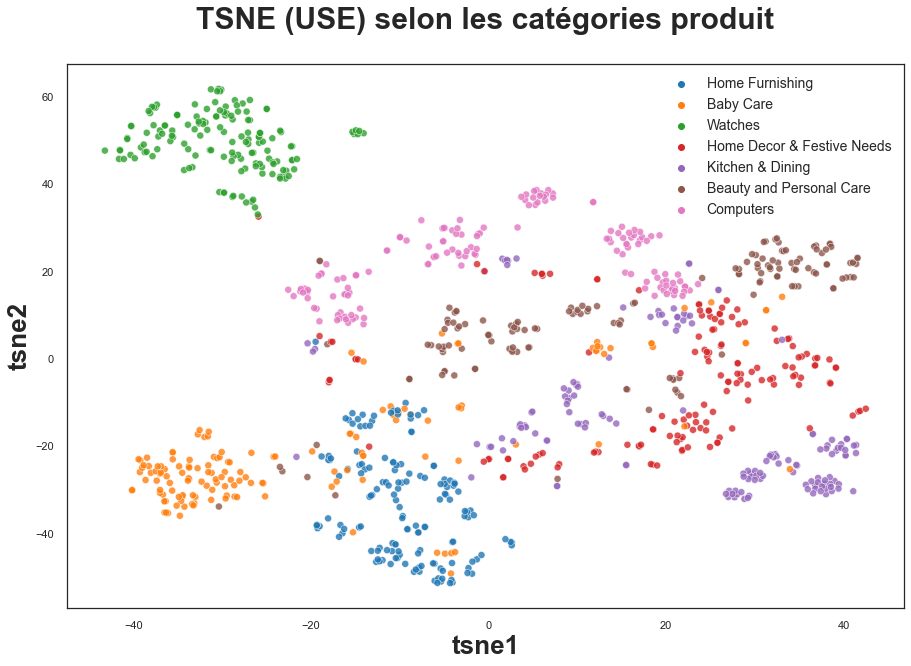

In [126]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_results_USE, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (USE) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


In [127]:
#Création de clusters à partir du T-SNE 
X = df_tsne_results_USE[["tsne1","tsne2"]]

cls_use = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls_use.fit(X)

df_tsne_results_USE["cluster"] = cls_use.labels_

sil = np.round(silhouette_score(X,cls_use.labels_,metric="euclidean"),2)
print("---------------------------")
print("Le score de silhouette est", sil)
print("---------------------------")

---------------------------
Le score de silhouette est 0.49
---------------------------


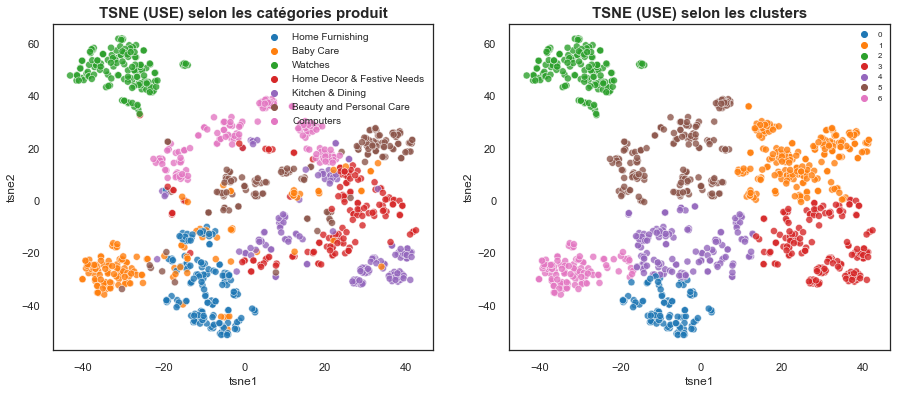

---------------------------
ARI :  0.407
---------------------------


In [128]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_results_USE, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (USE) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8, data=df_tsne_results_USE,legend="brief")

plt.title('TSNE (USE) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()

labels = df_txt["label"]
ARI_use=np.round(metrics.adjusted_rand_score(labels, cls_use.labels_),3)

print("---------------------------")
print(f"ARI : ",ARI_use)
print("---------------------------")
df_resultats = add_model_score(
    model_name='USE ', ARI=ARI_use)

In [129]:
df_tsne_results_USE.groupby("cluster").count()["class"]

cluster
0     97
1    214
2    151
3    166
4    145
5    169
6    108
Name: class, dtype: int64

- **Qualité de la catégorisation**

- **répartition des vraies catégories par cluster**

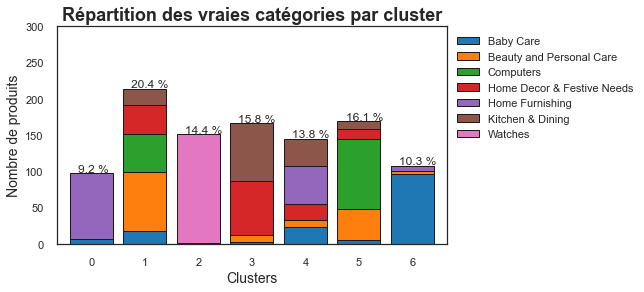

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0              6.00                      1.00       0.00   
1             18.00                     81.00      53.00   
2              0.00                      0.00       0.00   
3              2.00                     10.00       0.00   
4             23.00                     10.00       0.00   
5              5.00                     43.00      97.00   
6             96.00                      5.00       0.00   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                               0.00            90.00              0.00   
1                              40.00             0.00             22.00   
2                               1.00             0.00              0.00   
3                              74.00             0.00             80.00   
4                              22.00            53.00             37.00   
5                              13.00             1.00             10.00   
6                               0.00             6.00              1.00   

category  Watches  
label              
0            0.00  
1            0.00  
2          150.00  
3            0.00  
4            0.00  
5            0.00  
6            0.00

In [130]:
plot_clust_vs_cat(df_tsne_results_USE["cluster"],
                              df_tsne_results_USE["class"],
                              df_tsne_results_USE,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

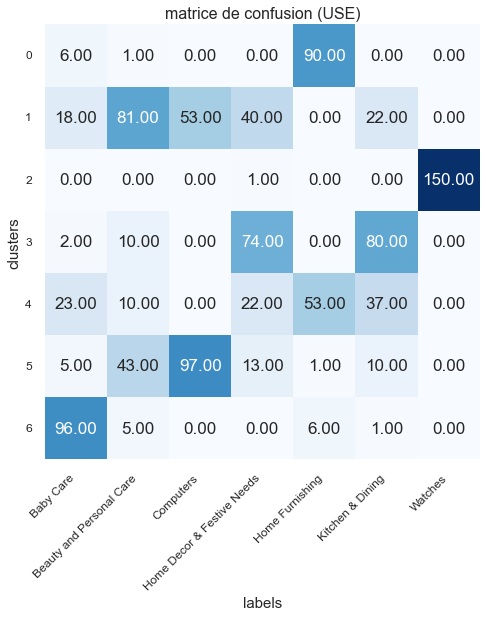

In [133]:
confusion_matrix( df_tsne_results_USE["class"],  df_tsne_results_USE["cluster"],
                 'matrice de confusion (USE)')

## Conclusion 

In [132]:
# Affichage des resultat 

df_resultats

model  ARI
0                       BOW  0.42
1                    TF-IDF  0.54
2                  Word2Vec  0.18
3  BERT (bert-base-uncased)  0.38
4      BERT(hub Tensorflow)  0.37
5                       USE  0.41

L’approches globales Tf-idf a montré des résultats prometteurs par rapport au autres approches 